# MILESTONE 2

`File name:` milestone2_kava.ipynb

`Authors:`
- Víctor González
- Alvaro Bautista 
- Alicia Soria 
- Kamil Czerniak

`Date created:` 05/11/2021

`Date last modified:` 12/11/2021

`Python Version:` 3.9.2


---

## Table of contents

**1. INTRODUCTION**
   * Context
   * Project idea
   * Project goals
   * Motivation
   * Feasibility
   
   
   
**2. THE DATA**
   * Quotebank
   * External data
    
    
    
**3. PIPELINE**
   * Load data and filtering
   * Examine and generic clean up
   * Expand Quotebank with Wikidata dumps, deep cleaning, exploration
   * Exploring and visualization
   * Modeling
   * Storytelling and communication
    
    
    
**4. CONCLUSIONS**
   * Summary
   * Results obtained
   * Problems encountered
    
    
    
**5. FUTURE LINES**

---

# 1. Introduction

### 1.1. Context
Welcome Milestone 2 Python notebook.
In this notebook we will answer several research questions surrounding the Breixit event.
We will employ the Quotebank dataset mainly, as well as additional datasets to enrich the data and obtain more
complete conclusions.

### 1.2. Project idea
In this study, we intend to clarify why Brexit has won over permanence in the EU, based on an analysis of quotations from the Quotebank dataset. The main objective is to provide the arguments used by those who support or oppose it during the period 2015-2020. To achieve this, the project first classifies citations in favor or against Brexit and then analyses the main arguments for each group. Finally, the data is supplemented with the information of the speakers, and the opinions are examined over time.

### 1.3. Project goals
The main goals of the project are:
- Determine and categorize the opinions of speakers supporting or opposing Brexit.
- Determine the reasons and arguments why the speakers support their opinion (supporting or opposing Brexit).
- Analyze and determine conclusions depending on speaker attributes (age, nationality, gender, profession...) and their opinion about Brexit.
- Study the change in the opinion and arguments of the speakers during the time, and especially due to important events related to Brexit.

### 1.4. Motivation
The UK's withdrawal from the EU, known as Brexit, is one of the most significant events of the 21st century. It has changed the whole life to a greater or lesser degree of millions of people, with political, economic, and social consequences, among other things. The Brexit referendum had a very tight result (48.1% against-51.9% in favor) and participation of 72.2%. Although it was in 2016, it is still a very important topic of conversation, mainly due to the long and complicated process of exiting the EU, with the official exit in 2020. Nonetheless, the process is not over yet, as the EU and UK must negotiate new trade agreements.

Nevertheless, how could this happen? Can we know which are the main reasons? How did the speakers had influenced the population? If you are interested, our project tries to clarify all these topics based on an analysis of quotations from the Quotebank dataset.

### 1.5. Feasibility
Before the completion of the project, we have researched Brexit and checked the feasibility of the project. The data source of the project is mainly the Quotebank dataset. We are working with the version provided by the professors, which includes the years from 2015 to March 2020. These dates fit perfectly with the Brexit topic, as the referendum was in June of 2016, so we can analyze before and post this date. Moreover, we can study the effect during all these years, when many other events have happened around Brexit. As well as Quotebank, we are using another dataset (Wikidata) to enrich the data of the speakers of the quotes. This second dataset can be easily merged with Quotebank, as both identify the speaker by the same identifier (QID). For more information about the datasets, read point 2.

In addition, the idea has been presented to the professors and we have obtained positive feedback about feasibility.

---

# 2. The data

## 2.1. Quotebank

This data source is described best by its makers:

>Quotebank is a dataset of 178 million unique, speaker-attributed quotations that were extracted from 196 million English news articles crawled from over 377 thousand web domains between August 2008 and April 2020. The quotations were extracted and attributed using Quobert, a distantly and minimally supervised end-to-end, language-agnostic framework for quotation attribution.

(*Vaucher, Timoté, Spitz, Andreas, Catasta, Michele, & West, Robert. (2021). Quotebank: A Corpus of Quotations from a Decade of News (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4277311 (accessible on November 10, 2021)*)

In our case, we will use data collected between January 2015 and April 2020. We decided to put the start date in 2015, as this was the year of General Election in the United Kingdom, where the Conservative Party (which won the majority in the House of Commons) has put a promise of an in-out referendum in its manifesto:

>We will negotiate new rules with the EU, so that people will have to be earning here for a number of years before they can claim benefits, including the tax credits that top up low wages. Instead of something-fornothing, we will build a system based on the principle of something-for-something. We will then put these changes to the British people in a straight in-out referendum on our membership of the European Union by the end of 2017.

(*The Conservative Party Manifesto 2015, http://ucrel.lancs.ac.uk/wmatrix/ukmanifestos2015/localpdf/Conservatives.pdf (accessible on November 10, 2021)*)

The data source is based on this paper: Timoté Vaucher, Andreas Spitz, Michele Catasta, and Robert West

"Quotebank: A Corpus of Quotations from a Decade of News"

Proceedings of the 14th International ACM Conference on Web Search and Data Mining (WSDM), 2021.

*https://doi.org/10.1145/3437963.3441760*

## Description of the data
- `quoteID:` Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
- `quotation:` Text of the longest encountered original form of the quotation
- `date:` Earliest occurrence date of any version of the quotation
- `phase:` Corresponding phase of the data in which the quotation first occurred (A-E)
- `probas:` Array representing the probabilities of each speaker having uttered the quotation. The probabilities across different occurrences of the same quotation are summed for each distinct candidate speaker and then normalized
 - `proba:` Probability for a given speaker
 - `speaker:` Most frequent surface form for a given speaker in the articles where the quotation occurred
- `speaker:` Selected most likely speaker. This matches the the first speaker entry in `probas`
- `qids:` Wikidata IDs of all aliases that match the selected speaker
- `numOccurrences:` Number of time this quotation occurs in the articles
- `urls:` List of links to the original articles containing the quotation 

### 2.2. External data

In order to get more context behind the speakers, we opted to use Wikidata dataset. This dataset, meant primarily for use in Wikimedia projects like Wikipedia or Wiktionary, contains properties and references describing an item, e.g., a person or a country. Because Quotebank uses Wikidata QIDs to refer to speakers, we can easily link persons to their attributes in Wikidata. 

Wikidata entries can contain an infinite number of attributes and references, so we have decided to use only a small number of attributes, which we can then use for demographic analysis. These attributes are:
- gender
- date of birth
- nationality
- occupation
- political party
- academic degree
- what political offices a person candidated for
- religion

All of these attributes are capable of containing multiple values (e.g., the entry for Angela Merkel marks her nationality as German and East German). 

This dataset, in its entirety, may have a size of about 100 GB, which is why we decided to use a subset provided by the course (named *speaker_attributes.parquet*). This subset contains these attributes (and a couple more that we opted not to use) for all speakers featured in Quotebank. In addition, we were provided with labels of all Wikidata entries used in the mentioned subset (*wikidata_labels_descriptions_quotebank.csv.bz2*), in order to dereference non-speaker attributes (like gender) more easily. 

#### References
- Wikidata website: https://www.wikidata.org/wiki/Wikidata:Main_Page
- Google Drive directory with preprocessed Wikidata dataset: https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0

---

# 3. Pipeline

**3.1) LOAD DATA AND FILTERING**
- Load data 
- Filter by Breixit quotes

**3.2) EXAMINE AND GENERIC CLEAN UP**
- Formats, shapes and data types
- Reading samples of quotes
- Duplicate values
    - Drop duplicates
- Missing values
    - In Quotebank
    - In Speakers_attributes
    - Remove empty quotes (quotebank)
    - Fill empty aliases with labels (speakers_attributes)
- Inconsistent and incorrect values
    - Find more than one qid for each speaker (indicate uncertainity)
    - Find more than one probas for each speaker (indicate uncertainity)
    - Get only first qid for each speaker
    - Missing speakers are associated with their second value in probas if > 40% prob
    - Add qid for the associated ones (use speakers_attributes.parquet)
    - Drop rows without found id


**3.3) EXPAND QUOTEBANK WITH WIKIDATA DUMPS, DEEP CLEANING, EXPLORATION**
- Merge with wikidata
- NLP cleaning
- Extracting summary statistics, distributions, correlations between columns
- First model approximation of linear regression
- Justify feasibility of data

**3.4) EXPLORING AND VISUALIZATION**

**3.5) MODELING**

**3.6) STORYTELLING AND COMMUNICATION**

**SOME COMMENTS**

We encourage you to use Google Colab for executing this part of notebook - Google Colab has support for Google Drive, which in turn has support for linking to external folders, allowing us to use larger datasets without losing space capacity on our accounts. In addition, step 3 relies on loading speaker attributes to memory before handling them - this requires ~6 GB of RAM, which could be an issue on computers with 8 GB of RAM or less.

Each step will generate its own output files, for each year, to limit the strain on following steps and allow analysis of what was removed in each step by comparing pre-step data.

We start by importing libraries that will be used in the pipeline. We also define years to be considered - this will be used to load files for each year and save the output.

In [13]:
#Import packages
import re, json, bz2
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re, string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
sw = stopwords.words('english')
import collections
from collections import Counter

print('Finished imports')

Finished imports


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victorgonzalez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

## 3.1. Load data and filtering
- Load data 
- Filter by Brexit quotes

The first step removes quotes that are not mentioning Brexit and as such are irrelevant to our analysis. We do this by using a regular expression that matches quotes that either contain the phrase "Brexit" or the combination of "leave", "leaving", "exit", "exiting" and "EU" or "European Union". We use a streaming approach used [here](https://colab.research.google.com/drive/1NqLFrAWAzKxr2dAWHI7m6Ml3gWGF72cA) in order to reduce the strain on RAM usage (each datasource file is approx. 2 GB in size).

**Input:** Compressed JSON file with quotes from Quotebank from given year, e.g., `quotes-{year}.json.bz2`

**Output:** Compressed JSON file with quotes mentioning Brexit from Quotebank from given year, e.g., `quotes-{year}-step1.json.bz2`

**NOTE**: due to large number of quotes, this step can take long time - possibly over an hour. You have been warned.

1) Load data from json and remove quotations without Breixit incidences. Run the second cell only if you want to regenerate data!

In [11]:
# Step 1: only keep quotes that contain phrases: Brexit OR ((leaving OR leave OR exiting OR exit) AND (EU or European Union))

YEARS = ["2015", "2016", "2017", "2018", "2019", "2020"]

def filterBrexitQuotes(year):
    regex_text = "(.*(brexit).*)|(.*(leave|leaving|exit|exiting).*(\W+eu\W+|\W+european union).*)"
    regex = re.compile(regex_text, re.IGNORECASE)
    path_to_file = f'./data/quotes-{year}.json.bz2' 
    path_to_out = f'./data/quotes-{year}-step1.json.bz2'

    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance) # loading a sample
                quotation = instance['quotation'] + " " # extracting quotation, space needed to match EU at the end of a sentence
                if(regex.match(quotation) is not None):
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in a new file

In [12]:
# Run this cell only if you need to refilter quotes
for year in YEARS:
    filterBrexitQuotes(year)

2) Load json files into dataframes

In [13]:
dfs_step_1 = dict()
for year in YEARS:
    dfs_step_1[year] = pd.read_json(f'./data/quotes-{year}-step1.json.bz2', compression='bz2', lines=True)

3) Add a new column in the dataframe with the year of the quotation

In [14]:
df_step2 = pd.DataFrame()
for year in YEARS:
    dfs_step_1[year]['year'] = int(year)
    df_step2 = df_step2.append(dfs_step_1[year], ignore_index=True)
df_step2.head(2)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
0,2015-02-26-101761,We don't necessarily want to leave the Europea...,None,[],2015-02-26 17:08:27,4,"[[None, 0.8607], [Marine Le Pen, 0.0754], [Fra...",[http://uk.reuters.com/article/2015/02/26/uk-f...,E,2015
1,2015-10-28-056860,I'm not arguing that all those who want to lea...,Laura Kuenssberg,[Q6499096],2015-10-28 15:47:22,2,"[[Laura Kuenssberg, 0.3141], [David Cameron, 0...","[http://home.nzcity.co.nz/nl.aspx?3397292, htt...",E,2015


4) Let's also load speaker attributes for further analysis in 3.2

In [5]:
df_speaker_attributes = pd.read_parquet('./data/speaker_attributes.parquet')

---

## 3.2. Examination and generic clean-up 

- Formats, shapes and data types
- Reading samples of quotes
- Duplicate values
    - Drop duplicates
- Missing values
    - In Quotebank
    - In Speakers_attributes
    - Remove empty quotes (quotebank)
    - Fill empty aliases with labels (speakers_attributes)
- Inconsistent and incorrect values
    - Find more than one qid for each speaker (indicate uncertainity)
    - Find more than one probas for each speaker (indicate uncertainity)
    - Get only first qid for each speaker
    - Missing speakers are associated with their second value in probas if > 40% prob
    - Add qid for the associated ones (use speakers_attributes.parquet)
    - Drop rows without found id



In this step, we will firstly analyze the formats, shapes and data types present in the database. 
Secondly, we observe a sample row of the database, the duplicate values, which we then drop, and the missing values in the quotes in certain rows which we then get rid of. Parallely, in the speakers_attributes dataset, the empty aliases are filled with the 'label' value. 
Thirdly, we observe the inconsistent or incorrect values which indicate uncertainity, such as having several qids for the same speaker or displaying several speaker probabilities for the same quote. 
In order to tackle these inconsistent or uncertain values, only the first qid is chosen for each speaker in Quotebank. Additionally, the quotes that do not have a speaker associated are given the speaker with the second highest probability as long as it is higher than a threshold, and their associated qid is found in the speakers_attributes dataset. Some qids are not found, so those rows are dropped.

**References:** NLP and Opinion Mining in Python. Sentiment Analysis of the Rayshard Brooks Shooting (François St-Amant, Jun 2020)

1) Analyze formats, shapes and data types present in the database

We begin by analyzing the whole Quotebank and speakers_attributes dataframes

In [17]:
df_step2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164006 entries, 0 to 164005
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   quoteID         164006 non-null  object        
 1   quotation       164006 non-null  object        
 2   speaker         164006 non-null  object        
 3   qids            164006 non-null  object        
 4   date            164006 non-null  datetime64[ns]
 5   numOccurrences  164006 non-null  int64         
 6   probas          164006 non-null  object        
 7   urls            164006 non-null  object        
 8   phase           164006 non-null  object        
 9   year            164006 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 12.5+ MB


In [18]:
df_speaker_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055981 entries, 0 to 9055980
Data columns (total 15 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   aliases             object
 1   date_of_birth       object
 2   nationality         object
 3   gender              object
 4   lastrevid           int64 
 5   ethnic_group        object
 6   US_congress_bio_ID  object
 7   occupation          object
 8   party               object
 9   academic_degree     object
 10  id                  object
 11  label               object
 12  candidacy           object
 13  type                object
 14  religion            object
dtypes: int64(1), object(14)
memory usage: 1.0+ GB


2) Reading a sample of quotes

In [19]:
df_step2.head(1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
0,2015-02-26-101761,We don't necessarily want to leave the Europea...,None,[],2015-02-26 17:08:27,4,"[[None, 0.8607], [Marine Le Pen, 0.0754], [Fra...",[http://uk.reuters.com/article/2015/02/26/uk-f...,E,2015


3) Find the duplicate values in Quotebank

 Duplicate values of  164006  total elements 

 Duplicated  quoteID :  0 
 Duplicated  quotation :  0 
 Duplicated  speaker :  148369 
 Duplicated  date :  52372 
 Duplicated  numOccurrences :  163560 
 Duplicated  phase :  164005 
 Duplicated  year :  164000 


/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


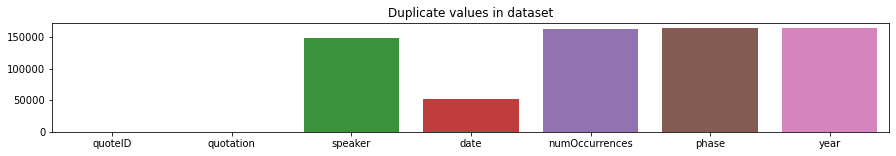

In [20]:
print('\033[0m','Duplicate values of ',len(df_step2),' total elements \n')

c=list(df_step2.columns)
c.remove('qids')
c.remove('probas')
c.remove('urls')
v = []

for m in c:
    print('\033[0m','Duplicated ',m,': ',df_step2.duplicated([m]).sum(),'')
    v.append(df_step2.duplicated([m]).sum())
fig, axs = plt.subplots(1, 1,figsize=(15,2))
sns.barplot(c,v)
axs.set_title('Duplicate values in dataset')
plt.show()

4) Duplicate values are dropped. In this case no row has a duplicate quotations or quoteIDs

In [21]:
df_step2 = df_step2.dropna(subset=['quotation','quoteID'])

5) Missing values are found in the Quotebank dataset

 Missing values of  164006  total elements 

 Missing  quoteIDs :  0 
 Missing  quotation :  0 
 Missing  speaker :  51779 
 Missing  qids :  51779 
 Missing  numOcurr :  0 
 Missing  probas :  0 


/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


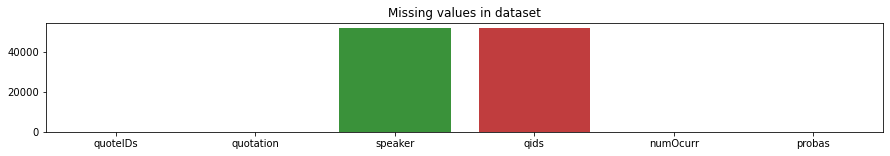

In [22]:
print('\033[0m','Missing values of ',len(df_step2),' total elements \n')

mqid = len(df_step2) -len(df_step2[df_step2["quoteID"].notnull()])
mq = len(df_step2) -len(df_step2[df_step2["quotation"].notna()])
ms = len(df_step2[df_step2["speaker"] == 'None'])
mqiss = len(df_step2[(df_step2.qids.apply(lambda x: len(x)==0))])
mno = len(df_step2[df_step2["numOccurrences"] == 0])
mp = len(df_step2[(df_step2.probas.apply(lambda x: len(x)==0))])

missing = ['quoteIDs','quotation','speaker','qids','numOcurr','probas']
vals = [mqid,mq,ms,mqiss,mno,mp]
for i in range(len(vals)):
    print('\033[0m','Missing ',missing[i],': ',vals[i],'')
    
fig, axs = plt.subplots(1, 1,figsize=(15,2))
sns.barplot(missing,vals)
axs.set_title('Missing values in dataset')
plt.show()

6) Find missing values in speakers_attributes dataset

 Missing values of  9055981  total elements 

 Missing  aliases :  7852579 
 Missing  date_of_birth :  4038648 
 Missing  nationality :  5340129 
 Missing  gender :  1950381 
 Missing  lastrevid :  0 
 Missing  ethnic_group :  8925596 
 Missing  US_congress_bio_ID :  9043107 
 Missing  occupation :  2682897 
 Missing  party :  8656805 
 Missing  academic_degree :  8955986 
 Missing  id :  0 
 Missing  label :  512300 
 Missing  candidacy :  8990539 
 Missing  religion :  8859697 


/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


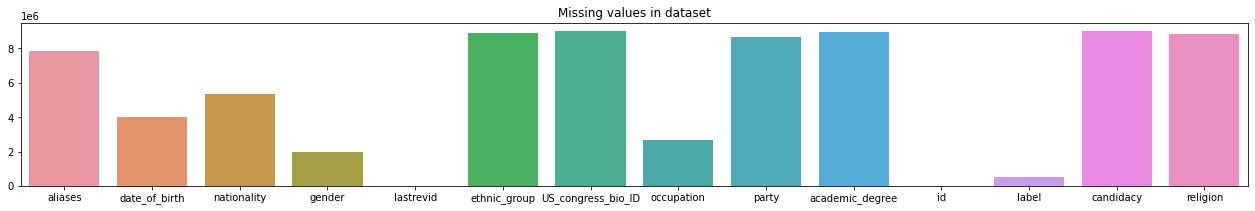

In [23]:
print('\033[0m','Missing values of ',len(df_speaker_attributes),' total elements \n')

vals = []
missing = ['aliases','date_of_birth','nationality','gender','lastrevid','ethnic_group','US_congress_bio_ID','occupation','party','academic_degree','id','label','candidacy','religion']
for m in missing:
    vals.append(len(df_speaker_attributes[df_speaker_attributes[m].isnull()]))
for i in range(len(vals)):
    print('\033[0m','Missing ',missing[i],': ',vals[i],'')

fig,axs = plt.subplots(1, 1,figsize=(22,3))
sns.barplot(missing,vals)
axs.set_title('Missing values in dataset')
plt.show()

7) Detect incorrect or inconsistent values that indicate uncertainity such as rows with several qids and/or several 
probabilities for the same quotation

 1  qids:  77185 ;  1  probas 0 
 2  qids:  16414 ;  2  probas 72265 
 3  qids:  5268 ;  3  probas 45155 
 4  qids:  2847 ;  4  probas 23907 
 5  qids:  1661 ;  5  probas 11280 
 6  qids:  1433 ;  6  probas 5400 
 7  qids:  1370 ;  7  probas 2641 


/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


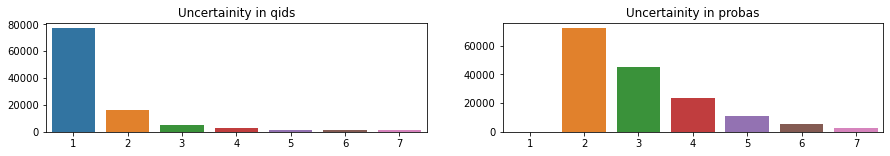

In [24]:
uncertainity = [1,2,3,4,5,6,7]
qids_uncert=[]
p_uncert = []
for d in uncertainity:
    u = len(df_step2[(df_step2.qids.apply(lambda x: len(x)==d))])
    qids_uncert.append(u)
    p = len(df_step2[(df_step2.probas.apply(lambda x: len(x)==d))])
    p_uncert.append(p)
    print('\033[0m',d,' qids: ',u,'; ',d,' probas',p,'')
fig, axs = plt.subplots(1, 2,figsize=(15,2))
sns.barplot(uncertainity,qids_uncert,ax=axs[0])
axs[0].set_title('Uncertainity in qids')
sns.barplot(uncertainity,p_uncert,ax=axs[1])
axs[1].set_title('Uncertainity in probas')
plt.show()

8) For each speaker, only the first qid is chosen

In [25]:
df_step2['unique_qids'] = df_step2.qids.apply(lambda y: [] if len(y)==0 else [y[0]]) # Find unique qids

9) For each quote with a missing speaker, they are associated their second highest value in the 'probas' column if the probability
is greater than a given threshold, in this case 40%

In [26]:
i = list(df_step2[df_step2.speaker=='None'].index) # First find the empty speakers
empty = df_step2.iloc[i]
indexes = [x for x in empty.index if float(empty.loc[x,'probas'][1][1])>0.4] # Where prob > X%
subs = [x[1][0] for x in df_step2.loc[indexes,'probas']] # get the second speaker after 'None'
b = zip(indexes,subs)
dn = pd.DataFrame(b)
xn = dn.set_index(0)
df_step2.loc[indexes,'speaker']= xn.loc[indexes,1] # Substitute the empty speaker for the second option
df_step2 = df_step2[df_step2.speaker!='None'] # Drop those that still are not filled

10) Taking a look at the speakers_attributes database, the empty aliases are filled with the 'label' value, if this field is also empty, that row is dropped

In [27]:
inull = df_speaker_attributes[df_speaker_attributes.aliases.isnull()].index
df_speaker_attributes.loc[inull,'aliases'] = df_speaker_attributes.loc[inull,'label']
df_speaker_attributes = df_speaker_attributes.dropna(subset=['aliases'])

11) For those newly associated speakers, their qid is found in the speakers_attributes table

In [28]:
# Find the indexes where the unique_qids are not filled
names_wo_id = list(df_step2[df_step2.unique_qids.apply(lambda x: len(x) ==0)]['speaker'])
names_wo_id_df = pd.DataFrame(names_wo_id).drop_duplicates()
names_wo_id = list(names_wo_id_df[0])

kv = []
for query in names_wo_id:
    idss=list(df_speaker_attributes[df_speaker_attributes.aliases.apply(lambda y: query in y)].id)
    theid = [idss[0]] if len(idss)>0 else None
    kv.append({'name':query,'qid':theid})

# Auxiliar dataframe with missing speakers and their qids
auxi = pd.DataFrame(kv)
auxi = auxi.dropna(subset=['qid'])
auxi = auxi.set_index('name')
keepindex = df_step2.index # store the index for later
df_step2 = df_step2.set_index('speaker') # change the index to the 'speakers'

# Speakers in quotebank are associated with their qid from speakers_attributes
df_step2.loc[auxi.index,'unique_qids'] = auxi.loc[auxi.index,'qid']
df_step2['speaker'] = df_step2.index # rescue the speakers' column
df_step2 = df_step2.set_index(keepindex) # rescue the previous index

12) There are some speakers that do not appear in the speakers_attributes aliases, therefore no qid is found, and those rows are dropped

In [29]:
# Rename 'NaN' the unique qids which are not filled so then its easier to drop them
df_step2.unique_qids = df_step2.unique_qids.apply(lambda y: np.nan if len(y)==0 else y)
df_step2=df_step2.dropna(0,subset=['unique_qids'])
df_step2['qids'] = df_step2['unique_qids']

# Reorder the columns because speaker was moved before when the index change
df_step2 = df_step2[["quoteID", "quotation", "speaker", "qids", "date", "numOccurrences", "probas", "urls", "phase", "unique_qids", "year"]]
df_step2 = df_step2.drop('unique_qids', axis=1)
df_step2 = df_step2.dropna(subset=['qids'])

/var/folders/4y/_4gs4vqd6lnb_3_131j1bk540000gn/T/ipykernel_4514/3671923134.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df_step2=df_step2.dropna(0,subset=['unique_qids'])


13) Finally, the database Quotebank is converted into a json in order to assign to it the information present in the Wikidata dumps

In [30]:
df_step2.to_json(path_or_buf='./data/df_step2.json.bz2', orient='records', compression='bz2', lines=True)

---

## 3.3: Expand with Wikidata dumps, deep cleaning & exploration
- Merge Quotebank with Wikidata dumps
- NLP cleaning
    - Remove capital letters, punctuations, emojis, links
    - Lemmatization
- Extracting summary statistics, distributions and correlations
- First model approximation of linear regression
- Justify feasibility of data

The third and final step involves matching each quote with attributes of its speaker. As mentioned above, this is done by looking into Wikidata subset datasource and grabbing attributes assigned to most likely speaker's Wikidata QID. Because some fields may be empty (due to missing data), we make sure that this case is handled correctly.

**Inputs:**
- compressed JSON file with quotes mentioning Brexit and with a known speaker from Quotebank from given year, e.g., `quotes-{year}-step2.json.bz2`

- Wikidata subset with data regarding speakers from Quotebank, stored as a .parquet file, i.e. `speaker_attributes.parquet`

- Wikidata subset with labels and descriptions of all references mentioned in .parquet Wikidata subset, i.e. `wikidata_labels_descriptions_quotebank.csv.bz2`

**Output:** Compressed JSON file with quotes mentioning Brexit and with a known speaker from Quotebank from given year, alongside attributes for speaker of each quote, e.g., `quotes-{year}-step3.json.bz2`

**NOTE:** Wikidata `.parquet` file is stored in memory, which could take ~6 GB of your RAM - please consider using Google Colab, which by default provides 12 GB of RAM.

1) Merge Wikidata dumps with improved Quotation dataframe and load dataframe from json. Run the first cell only if you want to regenerate data!

In [31]:
# Step 3: merge data from Quotebank and Wikidata
# NOTE: Wikidata parquet requires ~7 GB of RAM available - please use Colab for this step
# Run this ONLY if files are not generated
WD_ATTRIBUTES = ['gender', 'nationality', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']
df_speaker_attributes.set_index('id', inplace=True)
index_of_df_speaker_attributes = set(df_speaker_attributes.index)
wd_desc_df = pd.read_csv('./data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

path_to_file = f'./data/df_step2.json.bz2'
path_to_out = f'./data/df_step3.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            qid = list(index_of_df_speaker_attributes.intersection(set(instance['qids'])))
            if(len(qid) == 0):
                # Overall, two quotes get ignored due to no match in Wikidata
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) 
                continue
            # Special case: no label needed
            if (df_speaker_attributes['date_of_birth'][qid][0] is not None):
              instance['date_of_birth'] = df_speaker_attributes['date_of_birth'][qid][0].tolist()
            else:
              instance['date_of_birth'] = []
            for attribute in WD_ATTRIBUTES:
              if (df_speaker_attributes[attribute][qid][0] is not None):
                instance[attribute] = wd_desc_df['Label'][df_speaker_attributes[attribute][qid][0]].tolist()
              else:
                instance[attribute] = []
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

In [125]:
df_quotes = pd.read_json('./data/df_step3.json.bz2', compression='bz2', lines=True)

2) Remove capital letters, punctuations, emojis, links


In [126]:
def clean_text(text):
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    
    #Tokenize the data
    text = nltk.word_tokenize(text)
    #Remove stopwords
    text = [w for w in text if w not in sw]
    return text

df_quotes['quotation_cleaned'] = df_quotes['quotation'].apply(lambda x: clean_text(x))

3) Lemmatization: the process of grouping together the inflected forms of a word so they can be analyzed as a single item, since they have a similar meaning (walking becomes walk, officers becomes officer, etc.)


In [127]:
lemmatizer = WordNetLemmatizer()
def lem(text):
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [lemmatizer.lemmatize(t, 'v') for t in text]
    return text
df_quotes['quotation_cleaned'] = df_quotes['quotation_cleaned'].apply(lambda x: lem(x))
df_quotes=df_quotes.reset_index(drop=True)

4) Find histograms for the 10 most popular items of each category

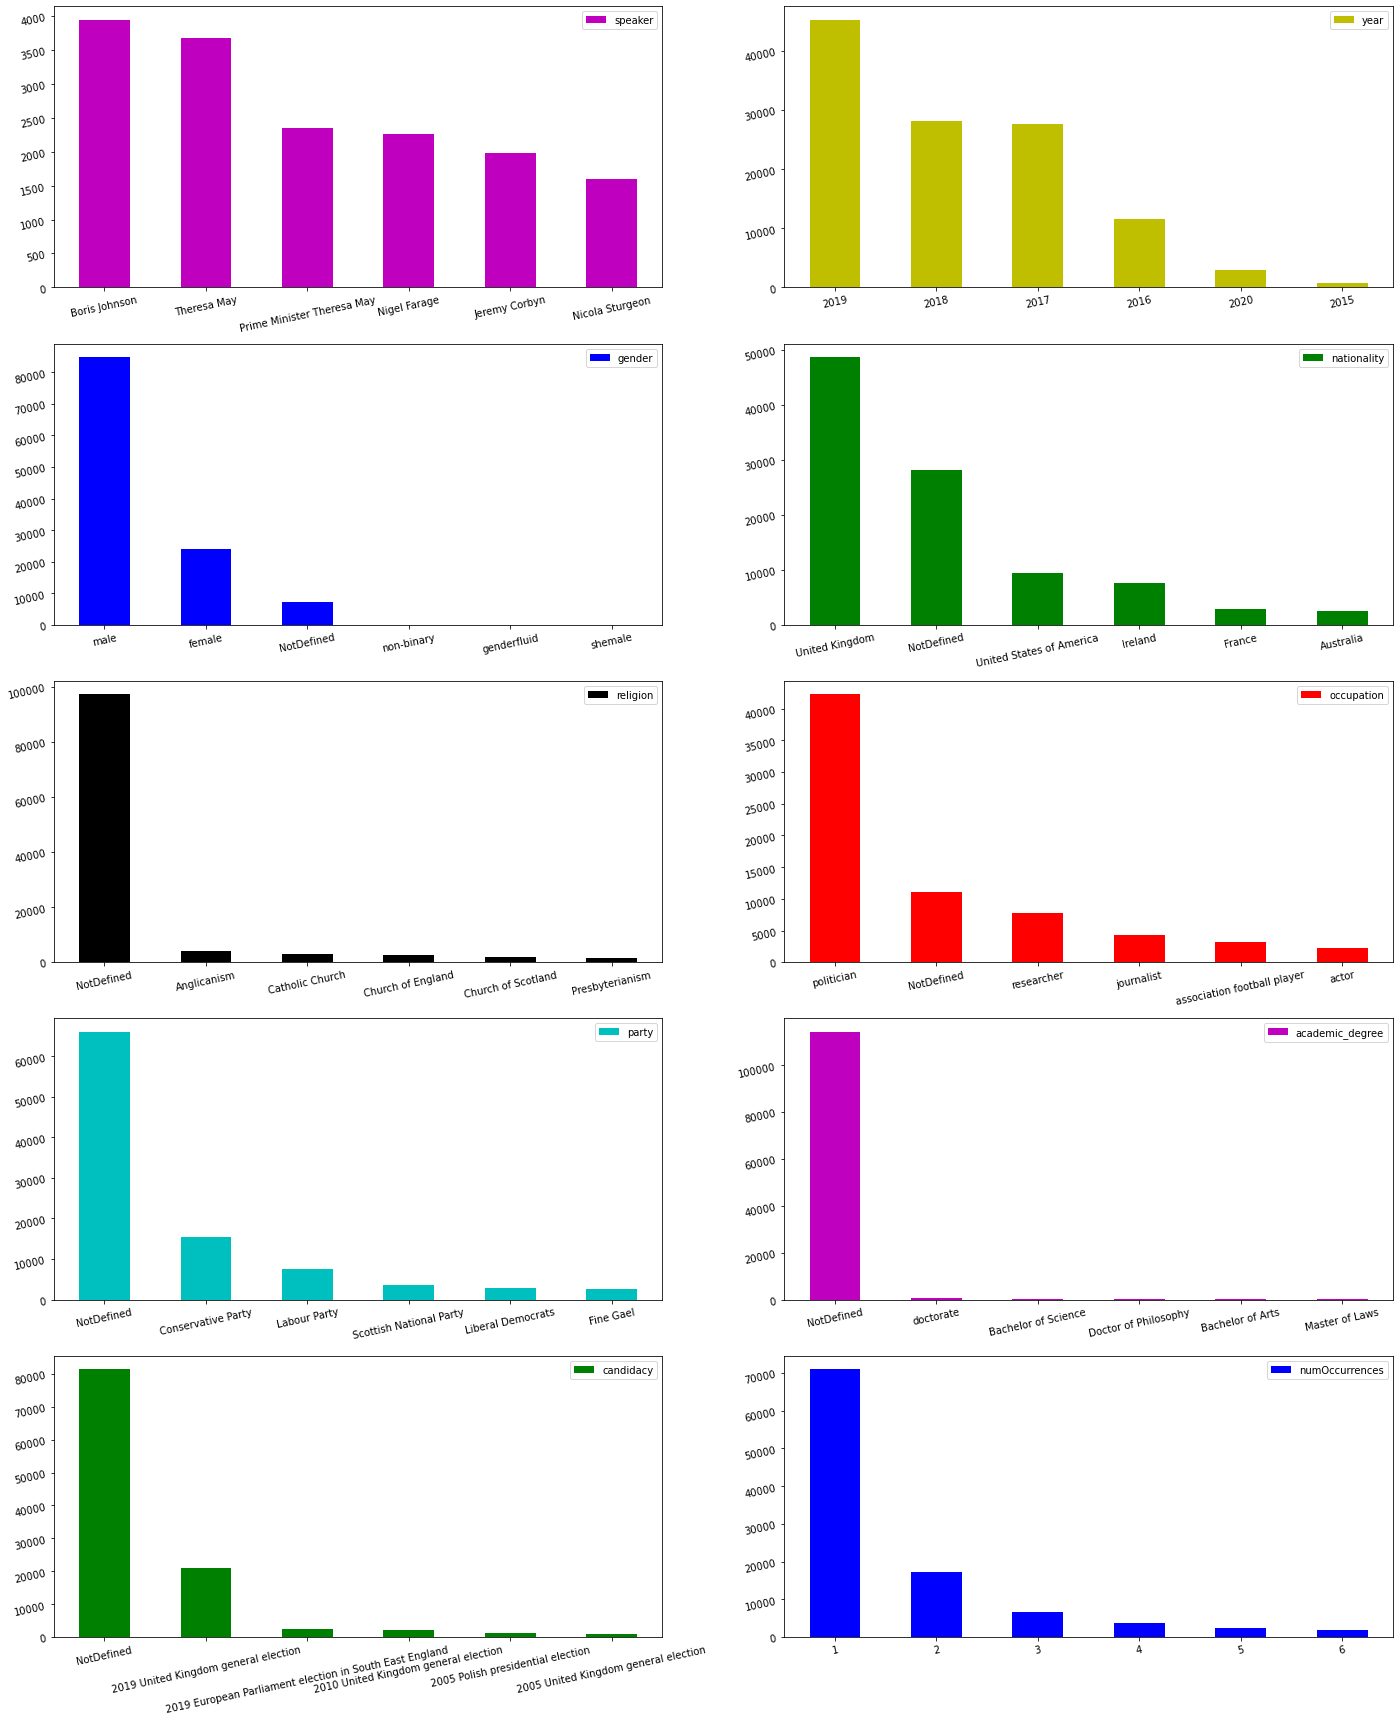

In [8]:
# Create an auxiliar dataframe employing only strings
pd_explore = pd.DataFrame()
pd_explore['speaker']= df_quotes.speaker
pd_explore['year']= df_quotes.year
pd_explore['gender']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.gender]
pd_explore['nationality']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.nationality]
pd_explore['religion']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.religion]
pd_explore['occupation']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.occupation]
pd_explore['party']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.party]
pd_explore['academic_degree']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.academic_degree]
pd_explore['candidacy']=[x[0] if (not (isinstance(x,float) and x!='nan') and len(x)>0) else 'NotDefined' for x in df_quotes.candidacy]
pd_explore['numOccurrences']= df_quotes.numOccurrences

heads = list(pd_explore.columns)
colors = ['m','y','b','g','k','r','c','m','g','b','y']
fig, axs = plt.subplots(int(len(heads)/2), 2,figsize=(24,30))
for n in range(len(heads)):
    f = int(np.floor(n/2))
    c = n%2
    plotting = list(pd_explore[heads[n]])
    letter_counts = Counter(plotting)
    a = letter_counts.most_common(6)
    b=pd.DataFrame(a)
    b=b.set_index(0)
    b.plot(kind='bar',ax = axs[f][c],color=colors[n])
    axs[f][c].legend({heads[n]})
    axs[f][c].set_xlabel("")
    axs[f][c].tick_params(labelrotation=12)
plt.show()

5) Drop the NotDefined data

In [9]:
pd_explore_2  = pd_explore[['speaker','year','gender','nationality','occupation','numOccurrences','party']]
withcorrfull = pd.DataFrame()
heads = list(pd_explore_2.columns)
for head in heads:
    withcorrfull[head] = [x  if x!='NotDefined' else None for x in pd_explore_2[head]]
notna_df = withcorrfull.dropna()

6) Find correlations between columns

In [10]:
cat_df = pd.DataFrame()
for head in heads:
    cat_df[head]=notna_df[head].astype('category').cat.codes
print('There are: ',len(cat_df),' values left')
cat_df.corr()


There are:  49704  values left


,speaker,year,gender,nationality,occupation,numOccurrences,party
speaker,1.000000,-0.004875,0.004234,-0.018427,-0.035610,0.000788,0.024696
year,-0.004875,1.000000,-0.017146,0.032433,0.047052,0.034154,-0.052013
gender,0.004234,-0.017146,1.000000,-0.132263,-0.061500,-0.013126,-0.018413
nationality,-0.018427,0.032433,-0.132263,1.000000,0.022839,0.015017,-0.162043
occupation,-0.035610,0.047052,-0.061500,0.022839,1.000000,0.005959,-0.012213
numOccurrences,0.000788,0.034154,-0.013126,0.015017,0.005959,1.000000,-0.010819
party,0.024696,-0.052013,-0.018413,-0.162043,-0.012213,-0.010819,1.000000


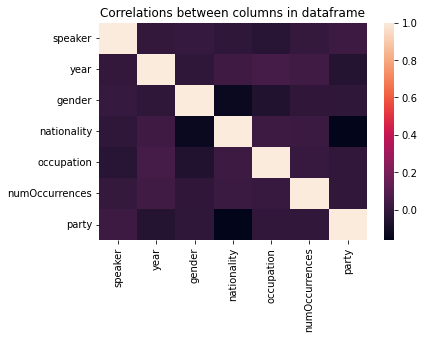

In [11]:
correlations=cat_df.corr()
sns.heatmap(correlations)
plt.title('Correlations between columns in dataframe')
plt.show()

7) First approximation of a model with linear regression

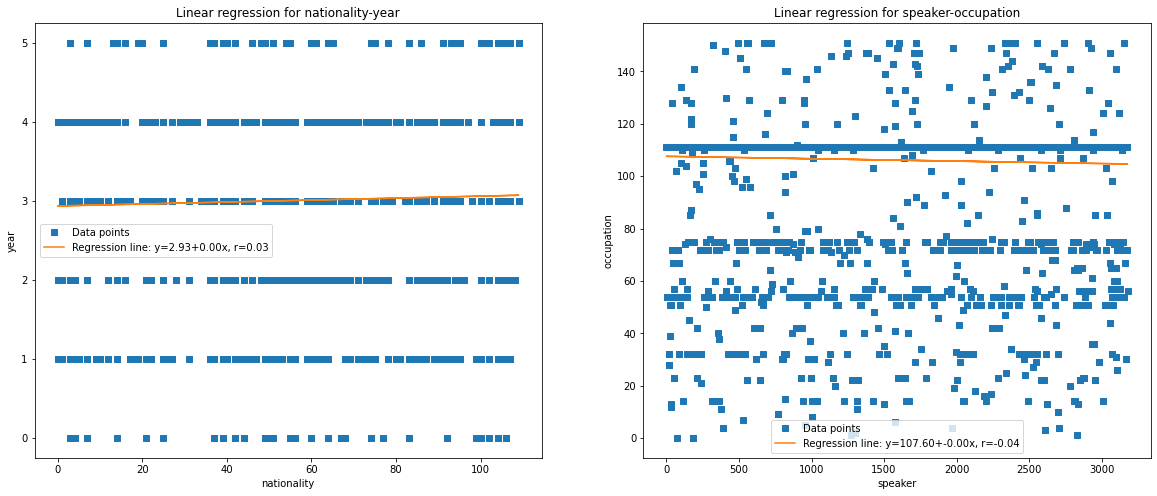

In [12]:
import scipy
fig, ax = plt.subplots(1,2, figsize=(20,8))

x = list(cat_df['nationality'])
y = list(cat_df['year'])

slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

ax[0].plot(x, y, linewidth=0, marker='s', label='Data points')
mm = [slope*float(i) for i in x]
ax[0].plot(x, intercept + mm, label=line)
ax[0].set_xlabel('nationality')
ax[0].set_ylabel('year')
ax[0].set_title('Linear regression for nationality-year')
ax[0].legend(facecolor='white')


x = list(cat_df['speaker'])
y = list(cat_df['occupation'])

slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

ax[1].plot(x, y, linewidth=0, marker='s', label='Data points')
mm = [slope*float(i) for i in x]
ax[1].plot(x, intercept + mm, label=line)
ax[1].set_xlabel('speaker')
ax[1].set_ylabel('occupation')
ax[1].set_title('Linear regression for speaker-occupation')
ax[1].legend(facecolor='white')


plt.show()

*Linear regression is not very useful, maybe find a model for categorization.*

8) Justify feasibility given the data
- Format is appropriate for analysis
- Enough quotes
- Quotes addressing the issue
- Different speakers involved
- Uniformity of speakers (not all from the same speaker)
- Uniformity of years quotes (not all from the same year)
- Long and short sentences
- Not many missing quotes
- Not many missing speakers
- No correlations between columns

## 3.4. Exploring and visualization

- Q1: Which percentage of the speakers supported or was against Brexit?
- Q2: What arguments did the members of each category use to support their beliefs? 
- Q3: Who were the main supporters of each of the categories? Analyze them according to age, gender, occupation, ...
- Q4: How did the opinion towards Brexit change during the 5 year span? Did the arguments of each group also change?

#### Q1: How did people really feel towards Brexit?

To answer this question we are going to use two different tools. 
The first one is Textblob’s sentiment function. This function allows us to look at:
- the `polarity` of a quote: by returning a float number that ranges from -1 (the most negative) to 1 (the most positive)
- the `subjectivity` of a quote: by returning a float number that ranges from 0 (very objective) to 1 (very subjective)

The second one is VADER (Valence Aware Dictionary and sEntiment Reasoner). VADER is "a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains". This library gives us a `compound` statistics which expresses the aggregated sentiment.

We defined a function get_sentiment(dataframe)that gets the polarity, subjectivity and compound for every quote, and then plotted the distribution of these statistics:

In [128]:
def get_sentiment(dataframe):
    '''
    Create a new column with the sentiment of the quote'
    :param dataframe: pandas.DataFrame
    :return: new dataframe
    '''
    sia = SentimentIntensityAnalyzer()
    #Get sentiment from comments
    dataframe['quotation_str'] = [str(thing) for thing in dataframe['quotation_cleaned']]
    polarity = []
    subjectivity = []
    sentiment = []
    for i in range(len(dataframe)):
        sentiment.append(sia.polarity_scores(dataframe['quotation'].iloc[i])['compound'])
        blob = TextBlob(dataframe['quotation_str'].iloc[i])
        for sentence in blob.sentences:
            polarity.append(sentence.sentiment.polarity)
            subjectivity.append(sentence.sentiment.subjectivity)
            
    dataframe['polarity']=polarity
    dataframe['subjectivity']=subjectivity
    dataframe['sentiment'] = sentiment
    return dataframe

In [ ]:
#Get polarity of quotes
df_quotes_with_sentiment = df_quotes
df_quotes_with_sentiment = get_sentiment(df_quotes_with_sentiment)

(0.0, 70000.0)

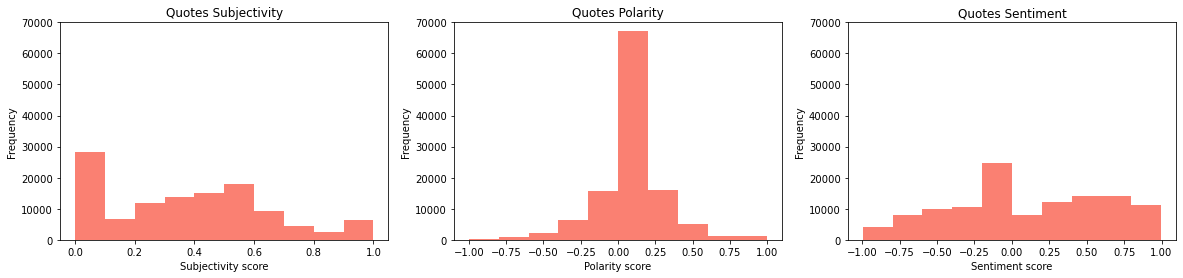

In [132]:
#Plot
fig, axs = plt.subplots(1, 3,figsize=(20,4))
df_quotes_with_sentiment['subjectivity'].plot.hist(color='salmon', title='Quotes Subjectivity', ax=axs[0])
df_quotes_with_sentiment['polarity'].plot.hist(color='salmon', title='Quotes Polarity', ax=axs[1])
df_quotes_with_sentiment['sentiment'].plot.hist(color='salmon', title='Quotes Sentiment', ax=axs[2])
axs[0].set_xlabel('Subjectivity score')
axs[1].set_xlabel('Polarity score')
axs[2].set_xlabel('Sentiment score')
axs[0].set_ylim(0, 70000)
axs[1].set_ylim(0, 70000)
axs[2].set_ylim(0, 70000)

As they're built differently, sentiment analysis tools don't always agree. Next step is to take a set of sentences and compare each analyzer's understanding of them, in order to check that the scores make sense and not blindly follow them.

In [21]:
scores = df_quotes_with_sentiment[["quotation", "polarity", "sentiment"]]
scores.head(20).style.background_gradient(cmap='RdYlGn', axis=None, low=0.4, high=0.4)

,quotation,polarity,sentiment
0,I'm not arguing that all those who want to leave the EU say they want to follow the Norwegian path but some do and I think it's very important in this debate that we are absolutely clear about the consequences of these actions.,0.150000,0.813600
1,One factor is the refugee crisis... Another obvious one is Britain wanting to possibly leave the European Union.,0.000000,-0.051600
2,This is combined with looming uncertainty over the timing and outcome of Britain's EU referendum. The General Election had the effect of pausing the uptick in employment in April and early May and Manpower Group expects `Brexit' uncertainty to have an even more dramatic impact.,-0.094444,-0.648600
3,"Whatever the promises made in the negotiations, there is no certainty that they will be delivered to the British people. Voters in the forthcoming referendum must be aware of this when they make their choice as to whether to vote to remain in the EU or to leave the EU.",0.125000,0.296000
4,"But if he does try to water down these protections, the right response is not to leave the EU but to fight the 2020 election on a clear commitment to restore those employment rights -- and we have to remain in the EU to do that,",0.223810,0.752300
5,"Given the breadth and depth of these overlapping interests, it is perhaps not surprising that Ireland regards the prospect of the UK leaving the EU as a major strategic risk.",0.062500,0.073600
6,"Our survey results are a worry and show that businesses in Ireland aren't taking the possibility of a `Brexit' seriously enough,",0.000000,-0.557400
7,"This whole humanitarian disaster is an indictment of the international community and the European Union. These people are leaving their countries because of turmoil -- a lot of that turmoil was created by interventions by Western powers, so we need to see the European Union and our Government doing more.",0.040000,-0.796400
8,"After we vote leave, we will negotiate a new UK-EU deal based on free trade and friendly co-operation,",0.027841,0.743000
9,"If leaving the EU was so cut and dried then why are not all businesses shouting to Government to do it? Small businesses are in fear of leaving the EU because their work, their trade, might dry up.",-0.127778,-0.713300


---
In order to decide which score to use, we analyzed the previous chart, comparing the used tools and how different the sources are:
- VADER focuses on content found everywhere, and it is known for being effective at general use. 
- TextBlob's two options are specific to certain domains. 

For this reason, we decided that VADER will be the most useful tool for us. 

---

In [136]:
df_quotes_with_sentiment['sentiment'].describe()

count    116227.000000
mean          0.113416
std           0.499884
min          -0.995500
25%          -0.273200
50%           0.038700
75%           0.536700
max           0.997500
Name: sentiment, dtype: float64

In [137]:
polarized_comments = len(df_quotes_with_sentiment.loc[(df_quotes_with_sentiment['sentiment'] < -0.5)|(df_quotes_with_sentiment['sentiment'] > 0.5)])
f'Number of extremely polarized comments: {polarized_comments}'

'Number of extremely polarized comments: 47779'

We use this score to classifying positive and negative sentiments in the different quotes. The conclusions we obtain are:
- We do not have a majority of neutral quotes, as we can appreciate how the sentiment follows a uniform distribution, with the mean quote having a sentiment score of 0.113416.
- In fact, 47779 of the 116227 quotes are considered to be very polarized (more than 0.5 or less than -0.5).



If we do a deeper analysis , we can classify the speakers based on the sentiment of their quotes. This will alow us to identify the opinion speakers have towards Brexit, and the percentages of positive and negative opinions it has.

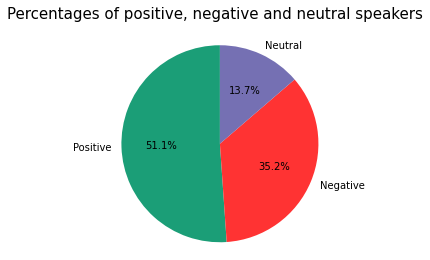

In [144]:
# Classify positive, negative and neutral quotes based on the polarity obtained
positive = df_quotes_with_sentiment.loc[df_quotes_with_sentiment['sentiment'] > 0]
positive_percentage = len(positive.index)/len(df_quotes_with_sentiment.index)
negative = df_quotes_with_sentiment.loc[df_quotes_with_sentiment['sentiment'] < 0]
negative_percentage = len(negative.index)/len(df_quotes_with_sentiment.index)
neutral = df_quotes_with_sentiment.loc[(df_quotes_with_sentiment['sentiment'] == 0)]
neutral_percentage = len(neutral.index)/len(df_quotes_with_sentiment.index)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive', 'Negative', 'Neutral'
colors = ['#1b9e77', '#f33', '#7570b3']
sizes = [positive_percentage, negative_percentage, neutral_percentage]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Percentages of positive, negative and neutral speakers',fontsize=15)
plt.show()

It is interesting to know this percentage and see how it has evolved over time. This will be deepened later on Q4. 

In [145]:
df_quotes_with_sentiment_2015 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2015]
df_quotes_with_sentiment_2016 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2016]
df_quotes_with_sentiment_2017 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2017]
df_quotes_with_sentiment_2018 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2018]
df_quotes_with_sentiment_2019 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2019]
df_quotes_with_sentiment_2020 = df_quotes_with_sentiment[df_quotes_with_sentiment['year'] == 2020]
positive_2015 = positive[(positive['year'] == 2015)]
positive_2016 = positive[(positive['year'] == 2016)]
positive_2017 = positive[(positive['year'] == 2017)]
positive_2018 = positive[(positive['year'] == 2018)]
positive_2019 = positive[(positive['year'] == 2019)]
positive_2020 = positive[(positive['year'] == 2020)]
negative_2015 = negative[(negative['year'] == 2015)]
negative_2016 = negative[(negative['year'] == 2016)]
negative_2017 = negative[(negative['year'] == 2017)]
negative_2018 = negative[(negative['year'] == 2018)]
negative_2019 = negative[(negative['year'] == 2019)]
negative_2020 = negative[(negative['year'] == 2020)]
neutral_2015 = neutral[(neutral['year'] == 2015)]
neutral_2016 = neutral[(neutral['year'] == 2016)]
neutral_2017 = neutral[(neutral['year'] == 2017)]
neutral_2018 = neutral[(neutral['year'] == 2018)]
neutral_2019 = neutral[(neutral['year'] == 2019)]
neutral_2020 = neutral[(neutral['year'] == 2020)]
# Classify supporters, detractors and neutral quotes based on the polarity obtained
positive_percentage_2015 = len(positive_2015.index)/len(df_quotes_with_sentiment_2015.index)
negative_percentage_2015 = len(negative_2015.index)/len(df_quotes_with_sentiment_2015.index)
neutral_percentage_2015 = len(neutral_2015.index)/len(df_quotes_with_sentiment_2015.index)
positive_percentage_2016 = len(positive_2016.index)/len(df_quotes_with_sentiment_2016.index)
negative_percentage_2016 = len(negative_2016.index)/len(df_quotes_with_sentiment_2016.index)
neutral_percentage_2016 = len(neutral_2016.index)/len(df_quotes_with_sentiment_2016.index)
positive_percentage_2017 = len(positive_2017.index)/len(df_quotes_with_sentiment_2017.index)
negative_percentage_2017 = len(negative_2017.index)/len(df_quotes_with_sentiment_2017.index)
neutral_percentage_2017 = len(neutral_2017.index)/len(df_quotes_with_sentiment_2017.index)
positive_percentage_2018 = len(positive_2018.index)/len(df_quotes_with_sentiment_2018.index)
negative_percentage_2018 = len(negative_2018.index)/len(df_quotes_with_sentiment_2018.index)
neutral_percentage_2018 = len(neutral_2018.index)/len(df_quotes_with_sentiment_2018.index)
positive_percentage_2019 = len(positive_2019.index)/len(df_quotes_with_sentiment_2019.index)
negative_percentage_2019 = len(negative_2019.index)/len(df_quotes_with_sentiment_2019.index)
neutral_percentage_2019 = len(neutral_2019.index)/len(df_quotes_with_sentiment_2019.index)
positive_percentage_2020 = len(positive_2020.index)/len(df_quotes_with_sentiment_2020.index)
negative_percentage_2020 = len(negative_2020.index)/len(df_quotes_with_sentiment_2020.index)
neutral_percentage_2020 = len(neutral_2020.index)/len(df_quotes_with_sentiment_2020.index)

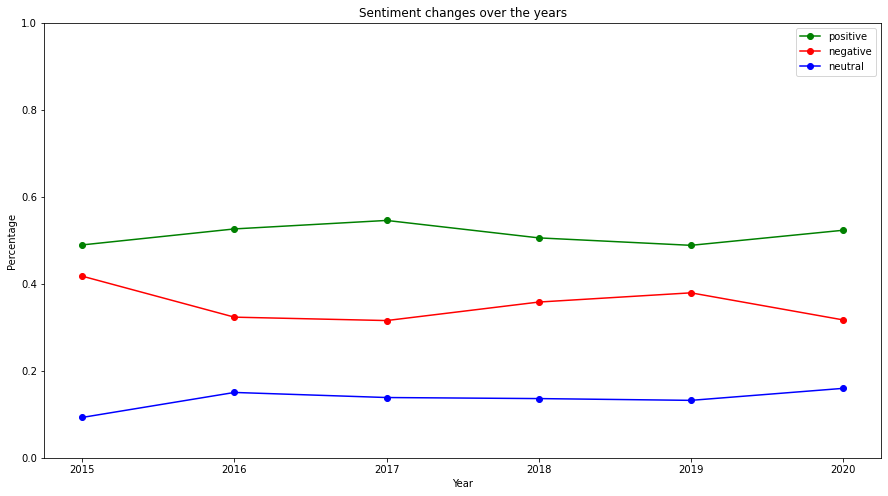

In [146]:
Year = [2015,2016,2017,2018,2019,2020]
supporters_percentages_years = [positive_percentage_2015, positive_percentage_2016,positive_percentage_2017, positive_percentage_2018, positive_percentage_2019, positive_percentage_2020 ]
detractors_percentages_years = [negative_percentage_2015, negative_percentage_2016,negative_percentage_2017, negative_percentage_2018, negative_percentage_2019, negative_percentage_2020 ]
neutral_percentages_years = [neutral_percentage_2015, neutral_percentage_2016,neutral_percentage_2017, neutral_percentage_2018, neutral_percentage_2019, neutral_percentage_2020 ]
fig, axs = plt.subplots(1, 1,figsize=(15,8))
plt.plot(Year, supporters_percentages_years, color='green', marker='o', label="positive")
plt.plot(Year, detractors_percentages_years, color='red', marker='o', label="negative")
plt.plot(Year, neutral_percentages_years, color='blue', marker='o', label="neutral")
plt.title('Sentiment changes over the years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.ylim([0, 1])
plt.legend()

plt.show()

As a last step, we can focus on the speakers whose nationality is British, so we can make a smarter approach of the problem.

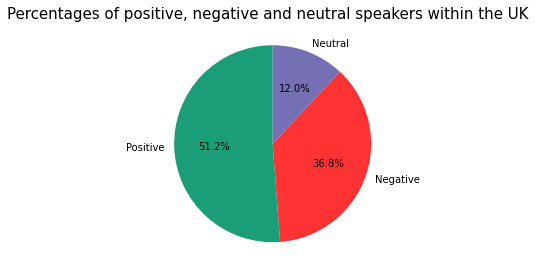

In [147]:
# Classify positive, negative and neutral quotes based on the sentiment obtained only for British speakers. 
positive_uk = positive[positive['nationality'].apply(lambda x: 'United Kingdom' in str(x))]
negative_uk = negative[negative['nationality'].apply(lambda x: 'United Kingdom' in str(x))]
neutral_uk = neutral[neutral['nationality'].apply(lambda x: x == ['United Kingdom'])]
total = len(positive_uk.index) + len(negative_uk.index) +  len(neutral_uk.index)
positive_uk_percentage = len(positive_uk.index)/total
negative_uk_percentage = len(negative_uk.index)/total
neutral_uk_percentage = len(neutral_uk.index)/total

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive', 'Negative', 'Neutral'
colors = ['#1b9e77', '#f33', '#7570b3']
sizes = [positive_uk_percentage, negative_uk_percentage, neutral_uk_percentage]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('Percentages of positive, negative and neutral speakers within the UK',fontsize=15)
plt.show()

If we analyze the two pie charts, we can see that the results are quite close to reality. The percentage of negative opinions (35.2%) is less than that of the supporters (51.1%), while there is a small percentage of neutral opinions (13.7%).

If we look at the percentages within the UK, the results are quite similar, and match what we expected.

It can be seen that the percentages are very similar to the previous ones, with a small increase in the negative opinions. We consider that this results are close to reality, as the atmosphere it is slightly more polarized within the country.

---

#### Q2: What arguments did the members of each category use to support their beliefs? 


To extract the most used arguments by the members of each category we are going to begin by looking at the word frequency of each group, i.e. what words are repeated most often in the quotes of each speakers. To achieve this we are going to use the FreqDist function from nltk.

This function gives us lists with the most frequent samples, bigrams and trigrams within the quotes. To clarify:

- a bigram is pair of words that are next to each other in a quote
- a trigram is trio of words that are next to each other in a quote

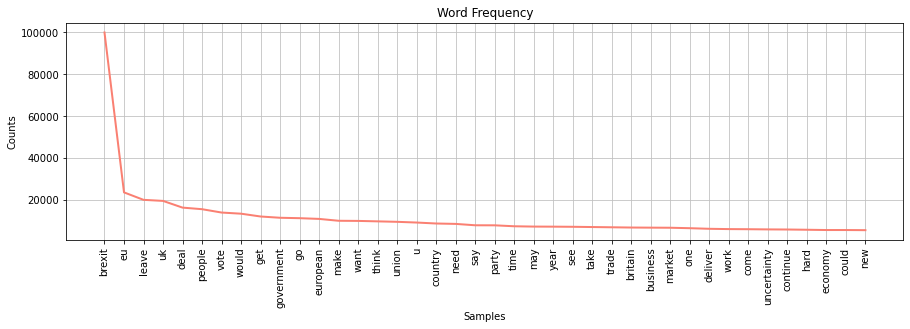

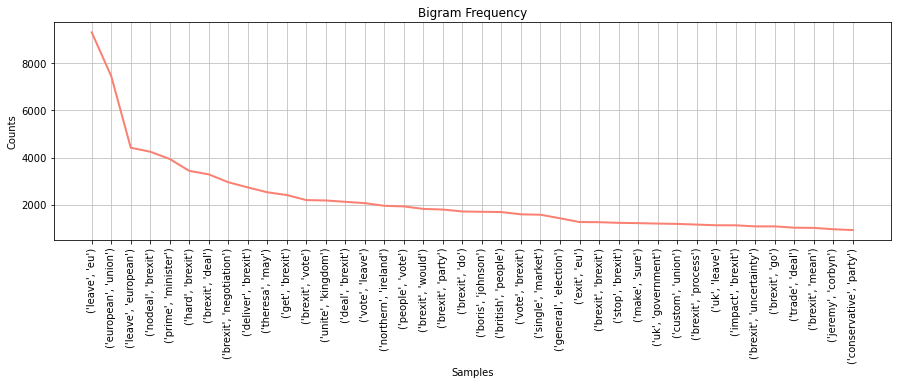

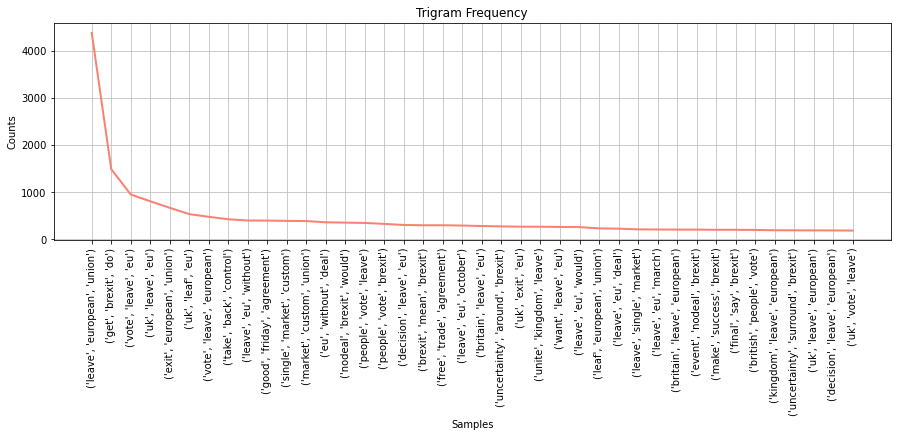

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [38]:
#From lists of quotes to a single list containing all words      
all_words=[]        
for i in range(len(df_quotes)):
    all_words = all_words + df_quotes['quotation_cleaned'].iloc[i]

#Get word frequency with ntlk
words_1 = nltk.FreqDist(all_words)
#Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigrm)
#Trigrams
trigrm = list(nltk.trigrams(all_words))
words_3 = nltk.FreqDist(trigrm)

In [150]:
words_3

FreqDist({('leave', 'european', 'union'): 4384, ('get', 'brexit', 'do'): 1491, ('vote', 'leave', 'eu'): 953, ('uk', 'leave', 'eu'): 810, ('exit', 'european', 'union'): 671, ('uk', 'leaf', 'eu'): 537, ('vote', 'leave', 'european'): 480, ('take', 'back', 'control'): 428, ('leave', 'eu', 'without'): 402, ('good', 'friday', 'agreement'): 400, ...})

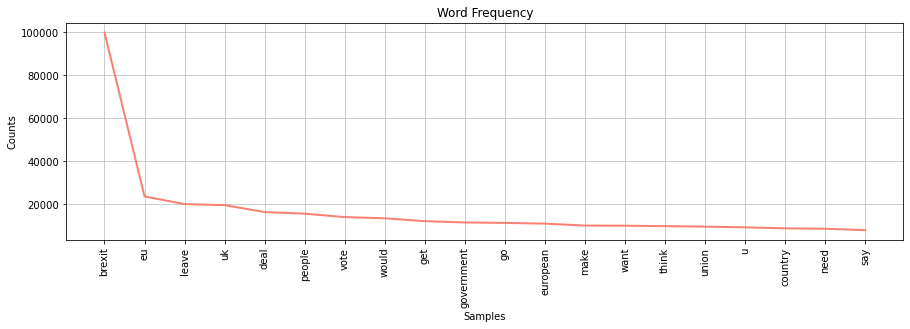

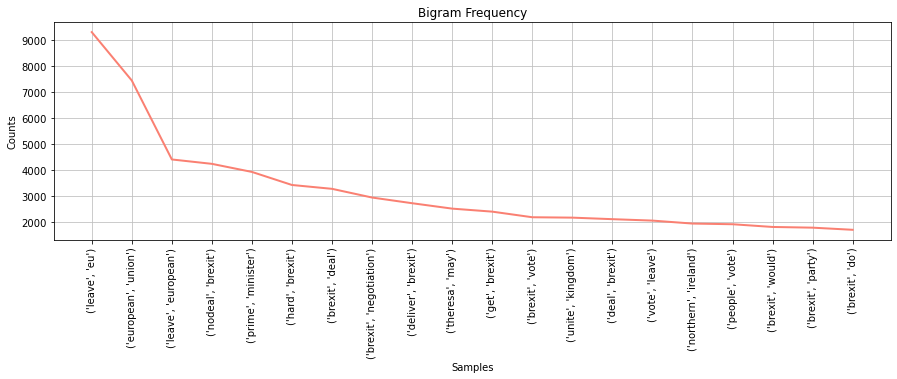

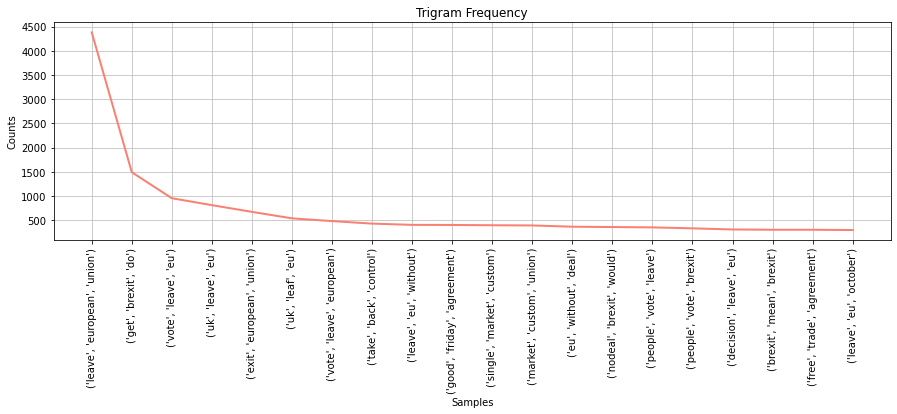

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [63]:
plt.figure(figsize=(15,4))
words_1.plot(20, color='salmon', title='Word Frequency')
plt.figure(figsize=(15,4))
words_2.plot(20, color='salmon', title='Bigram Frequency')
plt.figure(figsize=(15,4))
words_3.plot(20, color='salmon', title='Trigram Frequency')

---
To no one's surprise, 'Brexit' is the most repeated word with 99773 appearances, followed by 'eu' with 23554 and 'leave' with 20002.

If we analyze the bigrams, "leave eu" came up the most with 9320 appearances, followed by "european union" with 7457 and "leave european" with 4417. 

Related to the trigrams, "leave european union" appears the most a total of 4384 times, followed by "get brexit do" with 1491 appearances and "vote leave eu" with 953.

---

The previous analysis does not give us much idea about how people about Brexit overall.
To do an in-depth analysis, we are going to split the words between supporters and detractors, and try to extract conclussions from the arguments followed by each of the different groups.

In [151]:
#From lists of detractors quotes to a single list containing all detractors words      
negative_words=[]        
for i in range(len(negative)):
    negative_words = negative_words + negative['quotation_cleaned'].iloc[i]

#Get word frequency        
words_1_negative = nltk.FreqDist(negative_words)

#Bigrams
bigrm_negative = list(nltk.bigrams(negative_words))
words_2_negative = nltk.FreqDist(bigrm_negative)

#Trigrams
trigrm_negative = list(nltk.trigrams(negative_words))
words_3_negative = nltk.FreqDist(trigrm_negative)

In [152]:
# plt.figure(figsize=(15,4))
# words_1_negative.plot(20, color='salmon', title='Word Frequency')
# plt.figure(figsize=(15,4))
# words_2_negative.plot(20, color='salmon', title='Bigram Frequency')
# plt.figure(figsize=(15,4))
# words_3_negative.plot(20, color='salmon', title='Trigram Frequency')

<AxesSubplot:>

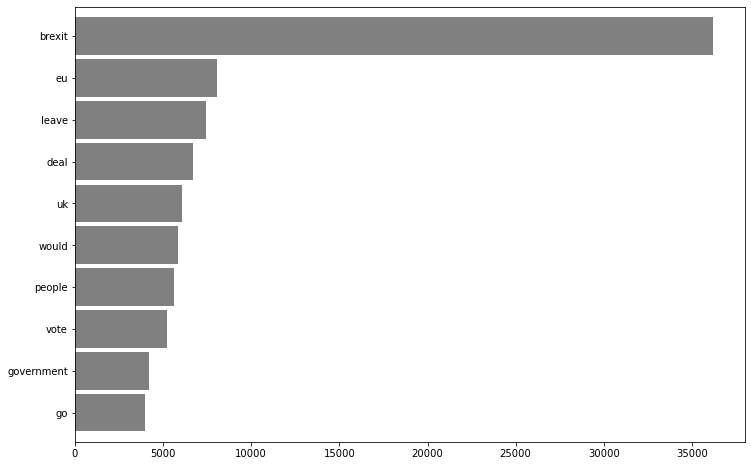

In [153]:
negative_series = pd.Series(negative_words).value_counts()[:10]
negative_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

<AxesSubplot:>

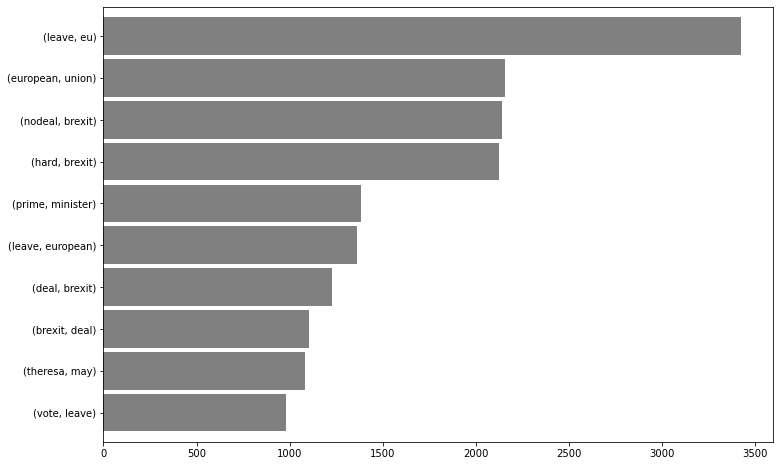

In [154]:
bigrams_negative_series = pd.Series(bigrm_negative).value_counts()[:10]
bigrams_negative_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

<AxesSubplot:>

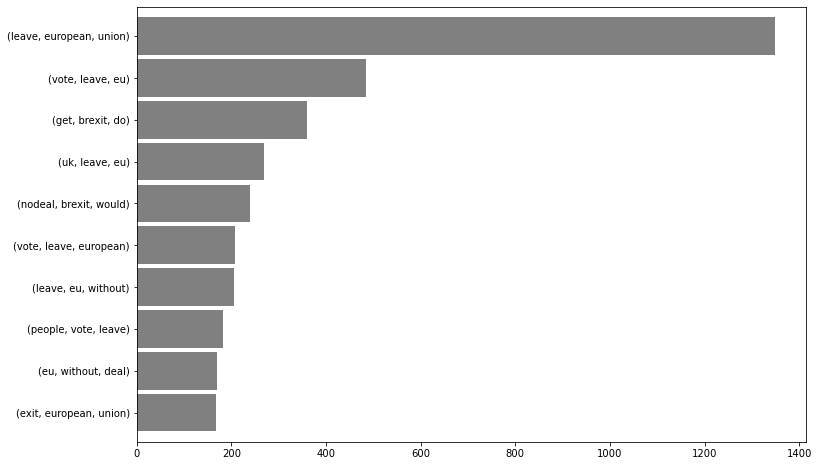

In [155]:
trigrams_negative_series = pd.Series(trigrm_negative).value_counts()[:10]
trigrams_negative_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

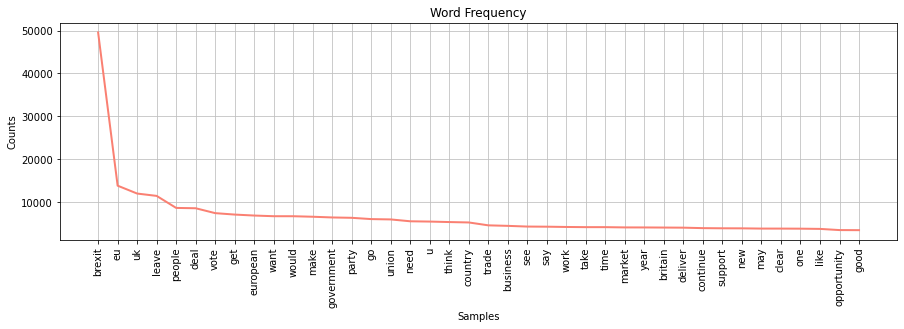

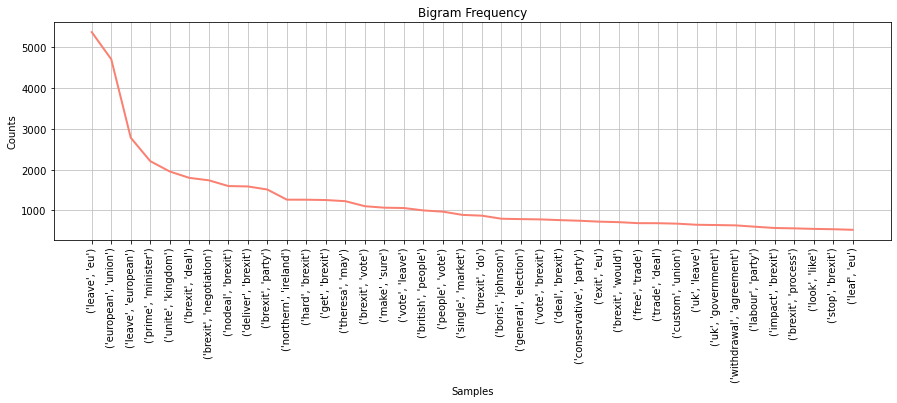

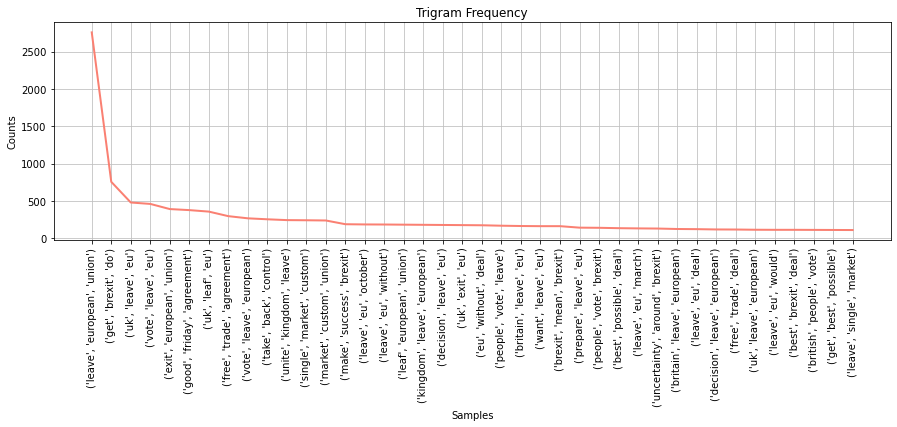

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [33]:
#From lists of supporters quotes to a single list containing all supporters words      
positive_words=[]        
for i in range(len(positive)):
    positive_words = positive_words + positive['quotation_cleaned'].iloc[i]

#Get word frequency        
words_1_positive = nltk.FreqDist(positive_words)

#Bigrams
bigrm_positive = list(nltk.bigrams(positive_words))
words_2_positive = nltk.FreqDist(bigrm_positive)

#Trigrams
trigrm_positive = list(nltk.trigrams(positive_words))
words_3_positive = nltk.FreqDist(trigrm_positive)

In [156]:
# plt.figure(figsize=(15,4))
# words_1_positive.plot(40, color='salmon', title='Word Frequency')
# plt.figure(figsize=(15,4))
# words_2_positive.plot(40, color='salmon', title='Bigram Frequency')
# plt.figure(figsize=(15,4))
# words_3_positive.plot(40, color='salmon', title='Trigram Frequency')

<AxesSubplot:>

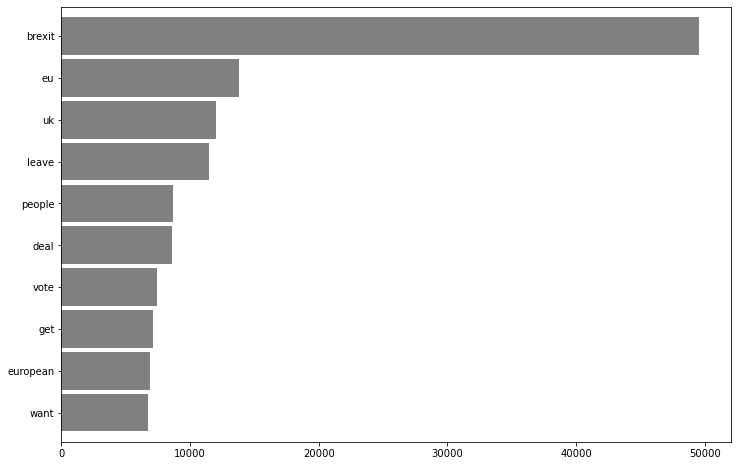

In [157]:
positive_series = pd.Series(positive_words).value_counts()[:10]
positive_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

<AxesSubplot:>

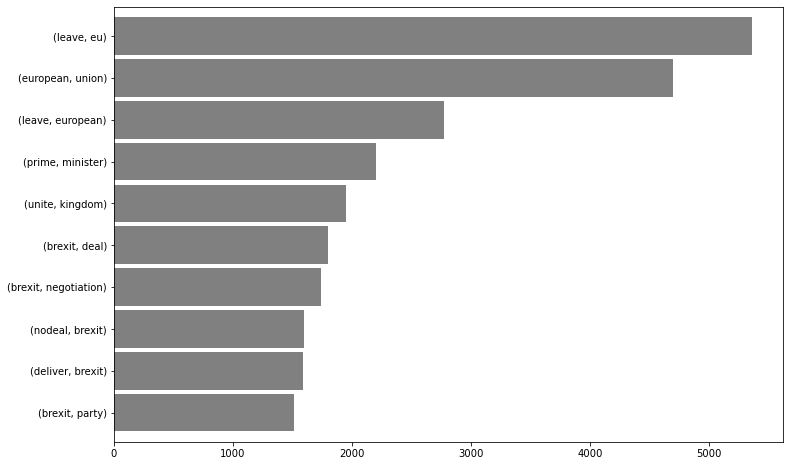

In [158]:
bigrams_positive_series = pd.Series(bigrm_positive).value_counts()[:10]
bigrams_positive_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

<AxesSubplot:>

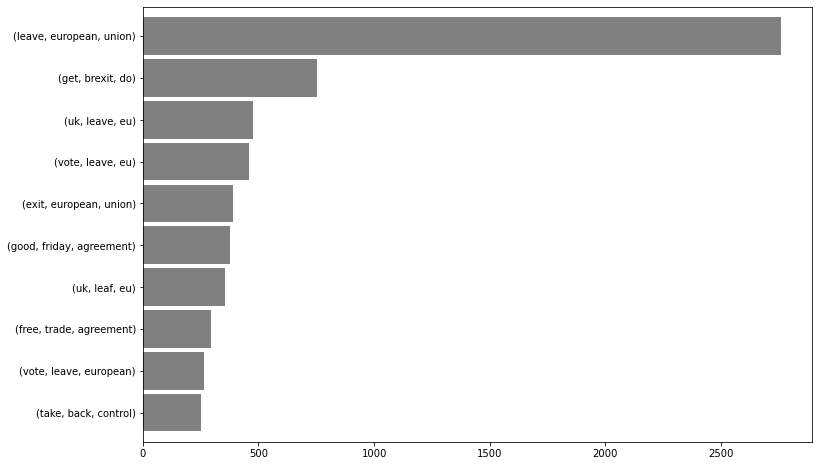

In [159]:
trigrams_positive_series = pd.Series(trigrm_positive).value_counts()[:10]
trigrams_positive_series.sort_values().plot.barh(color='grey', width=.9, figsize=(12, 8))

Once we have extracted all the words frecuency, we can see that the most repeated words and trigrams continue to be words or constructions related to the words "brexit", "european union", etc.

So in order to extract a more precise conclusion, we are going to compare both dictionaries, in order to obtain the words that differ in both of them.

In [93]:
# Comparing two dictionaries and checking how many (key, value) pairs are equal. Source: stack overflow. 
def dict_compare(d1, d2):
    '''
    Compare Create a new column with the sentiment of the quote'
    :param d1: dictionary 1
    :param d2: dictionary 2
    :return: d1_difference. List of keys present in d1 but not in d2.
    :return: d2_difference. List of keys pairs present in d2 but not in d1.
    :return: same. List of keys pairs present in both dictionaries.
    '''
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    shared_keys = d1_keys.intersection(d2_keys)
    d1_difference = list(d1_keys - d2_keys)
    d2_difference = list(d2_keys - d1_keys)
    same = set(o for o in shared_keys if d1[o] == d2[o])
    return d1_difference, d2_difference, same

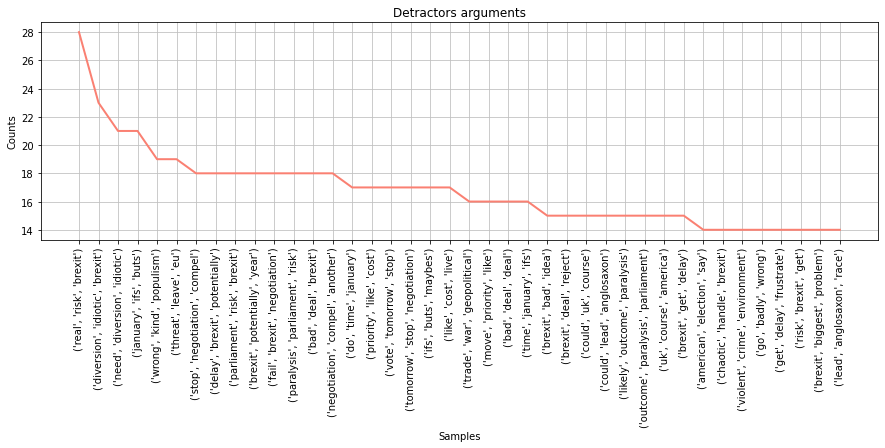

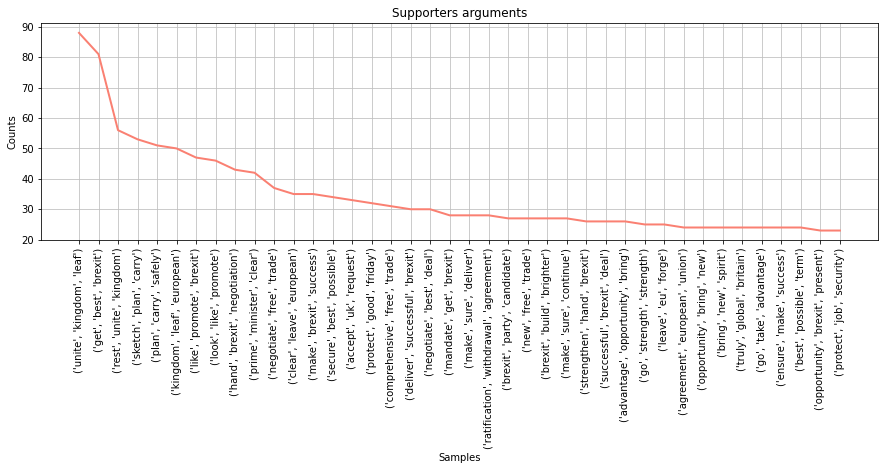

<AxesSubplot:title={'center':'Supporters arguments'}, xlabel='Samples', ylabel='Counts'>

In [115]:
# Compare supporters and detractors dictionaries and getting different keys. 
words_2_negative_different_keys, words_2_positive_different_keys, words_2_same_keys = dict_compare(words_2_negative, words_2_positive)
words_3_negative_different_keys, words_3_positive_different_keys, words_3_same_keys = dict_compare(words_3_negative, words_3_positive)

#Filter previous dictionaries to generate a new dictionary that contains the previous keys identified. Source: stack overflow
words_3_negative_differences = { words_3_negative_different_keys: words_3_negative[words_3_negative_different_keys] for words_3_negative_different_keys in words_3_negative_different_keys }
words_3_negative_differences_freq = nltk.FreqDist(words_3_negative_differences)
words_3_positive_differences = { words_3_positive_different_keys: words_3_positive[words_3_positive_different_keys] for words_3_positive_different_keys in words_3_positive_different_keys }
words_3_positive_differences_freq = nltk.FreqDist(words_3_positive_differences)

#Plot
plt.figure(figsize=(15,4))
words_3_negative_differences_freq.plot(40, color='salmon', title='Detractors arguments')
plt.figure(figsize=(15,4))
words_3_positive_differences_freq.plot(40, color='salmon', title='Supporters arguments')

---
After analyzing the different trigrams, we can highlight some of the quotes that sum up the thoughts of each group:
### alicias part

---

#### Q3: Who were the main supporters of each of the categories? Analyze them according to age, gender, occupation, ...


In [51]:
# Now we are working with 'gender', 'date_of_birth', 'nationality', 'occupation', 'party', 'academic_degree', 'candidacy' and 'religion' columns (data from Wikidata)
# Check and clean data with NaN values in supporters dataframe
positive_clean = positive.dropna(subset=['gender', 'date_of_birth', 'nationality', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion'])

In [52]:
# Check and clean data with NaN values in detractors dataframe
negative_clean = negative.dropna(subset=['gender', 'date_of_birth', 'nationality', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion'])

(0.0, 600.0)

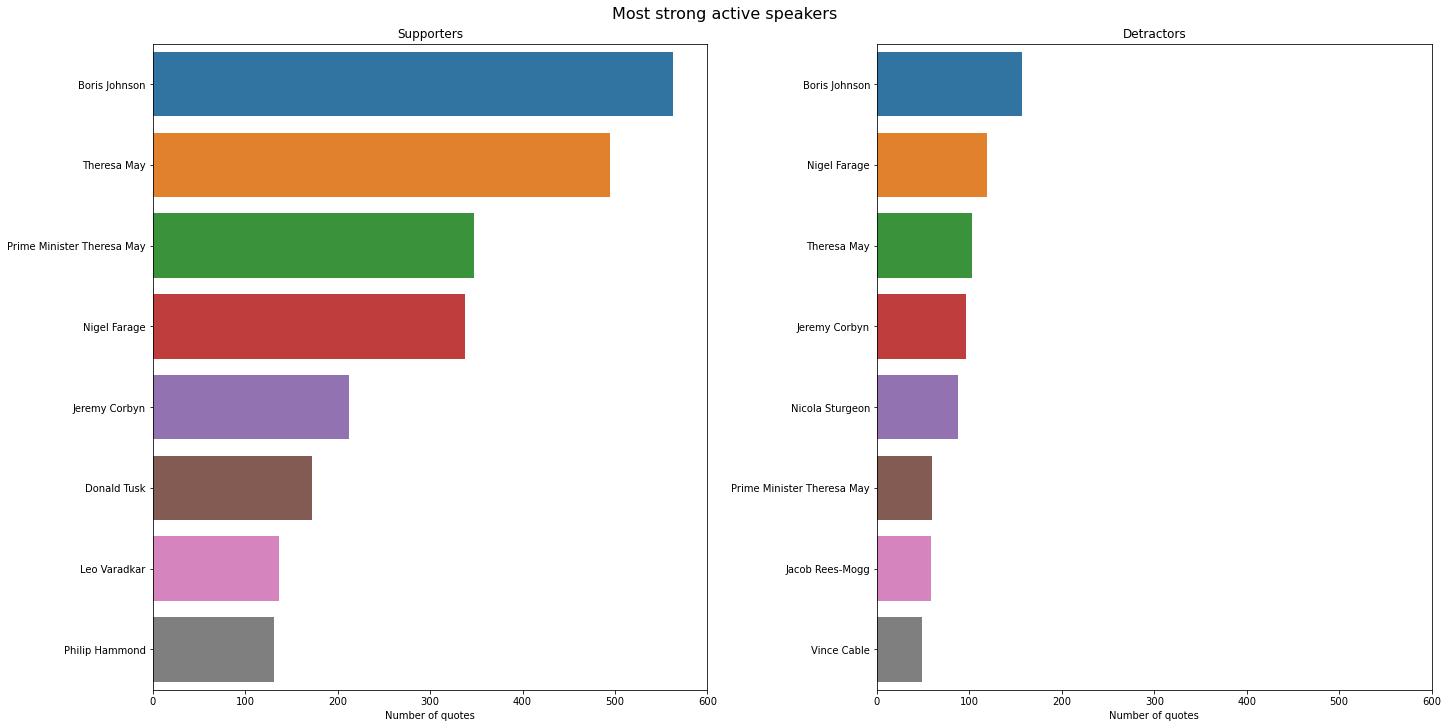

In [77]:
# Obtain most active speakers in supporters and detractors groups

# Define strong supporters as the ones with a sentiment above 0.3 and save the first 8 results
strong_supporters = positive_clean[positive_clean['polarity']>0.3]
strong_supporters_name = strong_supporters['speaker'].value_counts().head(8)

# Define strong detractors as the ones with a sentiment below -0.3 and save the first 8 results
strong_detractors = negative_clean[negative_clean['polarity']<-0.3]
strong_detractors_name = strong_detractors['speaker'].value_counts().head(8)

# Plot the results of most active supporters and detractors with the number of quotes per speaker
fig, axs = plt.subplots(1, 2,figsize=(20,10), constrained_layout=True)
fig.suptitle('Most strong active speakers', fontsize=16)
sns.barplot(x = strong_supporters_name.values, y = strong_supporters_name.index, ax = axs[0])
axs[0].set_title('Supporters')
axs[0].set_xlabel('Number of quotes')
sns.barplot(x = strong_detractors_name.values, y = strong_detractors_name.index, ax = axs[1])
axs[1].set_title('Detractors')
axs[1].set_xlabel('Number of quotes')

# Set the same x axis for both plots
axs[0].set_xlim([0,600])
axs[1].set_xlim([0,600])

---
We can observe that there are some important speakers related to Brexit (such as Boris Johnson or Theresa May) that appear in both groups, so we cannot obtain a conclusion related to the comparison between speakers with a different opinion.

On the other hand, we can check that these speakers are well known and have a strong relationship with the Brexit topic.

---

In [54]:
# Drop duplicates in strong supporters and strong detractors in order to have only each speaker once
strong_supporters_unique = strong_supporters.drop_duplicates(['speaker'])
strong_detractors_unique = strong_detractors.drop_duplicates(['speaker'])

# Calculate the percentage of male/female over the total in both supporters and detractors groups
# Some of the values in the column 'gender' are empty (so we do not have information if the speaker is male or female). For this reason, the total is above 100
strong_supporters_unique_male = (len(strong_supporters_unique[strong_supporters_unique['gender'].apply(lambda x: x == ['male'])]) / len(strong_supporters_unique))*100
strong_supporters_unique_female = (len(strong_supporters_unique[strong_supporters_unique['gender'].apply(lambda x: x == ['female'])]) / len(strong_supporters_unique))*100
strong_detractors_unique_male = (len(strong_detractors_unique[strong_detractors_unique['gender'].apply(lambda x: x == ['male'])]) / len(strong_detractors_unique))*100
strong_detractors_unique_female = (len(strong_detractors_unique[strong_detractors_unique['gender'].apply(lambda x: x == ['female'])]) / len(strong_detractors_unique))*100

# Create DataFrame in long format with position, gender, and percentage columns in order to plot the results
df_gender = pd.DataFrame({'Position': ['Strong supporters', 'Strong supporters', 'Strong detractors', 'Strong detractors'], 'Gender':['Male', 'Female', 'Male', 'Female'], 'Percentage':[strong_supporters_unique_male, strong_supporters_unique_female, strong_detractors_unique_male, strong_detractors_unique_female]})
df_gender

,Position,Gender,Percentage
0,Strong supporters,Male,80.216675
1,Strong supporters,Female,17.333961
2,Strong detractors,Male,79.899244
3,Strong detractors,Female,17.531486


<AxesSubplot:xlabel='Gender', ylabel='Percentage'>

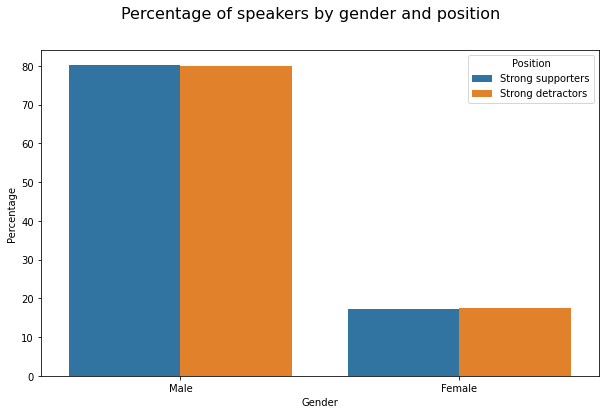

In [55]:
# Plot the percentage of speakers by gender and position (strong supporters and strong detractors)
fig, axs = plt.subplots(figsize=(10,6))
fig.suptitle('Percentage of speakers by gender and position', fontsize=16)
sns.barplot(data=df_gender, x = 'Gender', y = 'Percentage', hue='Position')

---
We can observe that in both cases the percentage of males/females is almost equal, so we cannot see significant differences regarding the gender between speakers with a different opinion toward Brexit.
However, we can observe that in both cases the speakers are mainly male (80%), which shows that the current political environment is dominated by them.

---

In [56]:
# Initialize auxiliary arrays to store all the countries from supporters and detractors
array_countries_supporters = []
array_countries_detractors = []

# Save in 'array_countries_supporters' all the values from the input 
# input: array of values
def save_countries_supporters(input):
    for x in input:
        array_countries_supporters.append(x)

# Save in 'array_countries_detractors' all the values from the input 
# input: array of values
def save_countries_detractors(input):
    for x in input:
        array_countries_detractors.append(x)

# Cycle nationality values of each speaker, and save it in auxiliary arrays
# Some speakers have several countries in the nationality column
strong_supporters_unique['nationality'].apply(lambda x: save_countries_supporters(x))
strong_detractors_unique['nationality'].apply(lambda x: save_countries_detractors(x))

17        None
32        None
36        None
55        None
63        None
          ... 
115797    None
115932    None
115992    None
116079    None
116083    None
Name: nationality, Length: 1985, dtype: object

In [57]:
# Convert auxiliary arrays into Series for handling better the data and plotting
# Count most common values
serie_countries_supporters = pd.Series(array_countries_supporters, name='supporter_speakers').value_counts()
serie_countries_detractors = pd.Series(array_countries_detractors, name='detractor_speakers').value_counts()

# Outer merge (common and not common values) of the series of the supporter and detractor countries
df_countries = pd.merge(serie_countries_supporters, serie_countries_detractors, left_index=True, right_index=True, how='outer')

# Fill with 0 the NaN values. As it is an outer merge, NaN values are possible (countries in one serie but not in the another)
df_countries['supporter_speakers'] = df_countries['supporter_speakers'].fillna(0)
df_countries['detractor_speakers'] = df_countries['detractor_speakers'].fillna(0)

# Reset index of DataFrame and rename by 'country'
df_countries.reset_index(inplace=True)
df_countries.rename({'index' : 'country'}, axis=1, inplace=True)

# Sort values in descending direction and limit them to the top 10
df_countries = df_countries.sort_values(by=['supporter_speakers', 'detractor_speakers'], ascending=False).head(10)

# Convert the DataFrame from wide format to long format in order to plot it easily
df_countries_long = pd.melt(df_countries, id_vars="country", var_name="type_speakers", value_name="number_speakers")

In [58]:
# Calculate the percentage of each country over the total in both supporters and detractors groups
df_countries_percentage = df_countries
df_countries_percentage['supporter_speakers'] = ( df_countries['supporter_speakers'] / len(array_countries_supporters) )*100
df_countries_percentage['detractor_speakers'] = ( df_countries['detractor_speakers'] / len(array_countries_detractors) )*100

# Convert the DataFrame from wide format to long format in order to plot it easily
df_countries_percentage_long = pd.melt(df_countries_percentage, id_vars="country", var_name="type_speakers", value_name="number_speakers_percentage")

Text(0.5, 1.0, 'Relative values')

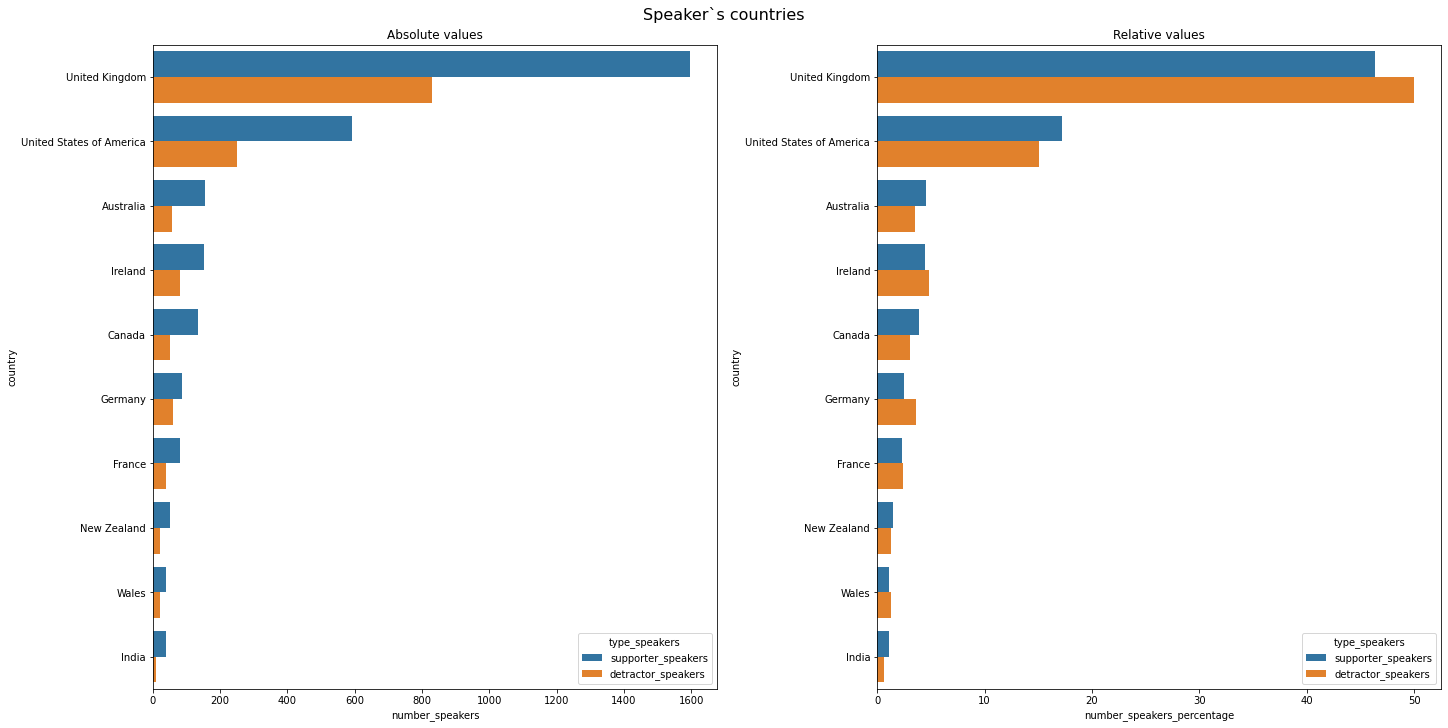

In [59]:
# Plot the results of the speaker's countries analysis
# Left plot: speaker's countries absolute values
# Right plot: speaker's countries relative values
fig, axs = plt.subplots(1, 2,figsize=(20,10), constrained_layout=True)
fig.suptitle('Speaker`s countries', fontsize=16)
sns.barplot(data = df_countries_long, x = 'number_speakers', y = 'country', hue = 'type_speakers', ax = axs[0])
axs[0].set_title('Absolute values')
sns.barplot(data = df_countries_percentage_long, x = 'number_speakers_percentage', y = 'country', hue = 'type_speakers', ax = axs[1])
axs[1].set_title('Relative values')

---
As the total number of supporter and detractor speakers is not equal, it is better to compare relative values regarding the total speakers of each group. Analyzing the relative values, we can conclude that:
- Most of the speaker's nationalities have almost the same percentage of supporter and detractor speakers, although normally it is superior the number of supporters
- Some countries such as Germany and Luxembourg have a considerably higher percentage of a detractor than supporters speakers. This may make sense, as they are countries that support the permanence of the UK in the EU.

---

In [60]:
# Initialize auxiliary arrays to store all the occupations from supporters and detractors
array_occupations_supporters = []
array_occupations_detractors = []

# Save in 'array_occupations_supporters' all the values from the input 
# input: array of values
def save_occupations_supporters(input):
    for x in input:
        array_occupations_supporters.append(x)

# Save in 'array_occupations_detractors' all the values from the input 
# input: array of values
def save_occupations_detractors(input):
    for x in input:
        array_occupations_detractors.append(x)

# Cycle occupation values of each speaker, and save it in auxiliary arrays
# Some speakers have several occupations in the occupation column
strong_supporters_unique['occupation'].apply(lambda x: save_occupations_supporters(x))
strong_detractors_unique['occupation'].apply(lambda x: save_occupations_detractors(x))

17        None
32        None
36        None
55        None
63        None
          ... 
115797    None
115932    None
115992    None
116079    None
116083    None
Name: occupation, Length: 1985, dtype: object

In [61]:
# Convert auxiliary arrays into Series for handling better the data and plotting
# Count most common values
serie_occupations_supporters = pd.Series(array_occupations_supporters, name='supporter_speakers').value_counts()
serie_occupations_detractors = pd.Series(array_occupations_detractors, name='detractor_speakers').value_counts()

# Outer merge (common and not common values) of the series of the supporter and detractor occupations
df_occupations = pd.merge(serie_occupations_supporters, serie_occupations_detractors, left_index=True, right_index=True, how='outer')

# Fill with 0 the NaN values. As it is an outer merge, NaN values are possible (occupations in one serie but not in the another)
df_occupations['supporter_speakers'] = df_occupations['supporter_speakers'].fillna(0)
df_occupations['detractor_speakers'] = df_occupations['detractor_speakers'].fillna(0)

# Reset index of DataFrame and rename by 'occupation'
df_occupations.reset_index(inplace=True)
df_occupations.rename({'index' : 'occupation'}, axis=1, inplace=True)

# Sort values in descending direction and limit them to the top 10
df_occupations = df_occupations.sort_values(by=['supporter_speakers', 'detractor_speakers'], ascending=False).head(10)

# Convert the DataFrame from wide format to long format in order to plot it easily
df_occupations_long = pd.melt(df_occupations, id_vars="occupation", var_name="type_speakers", value_name="number_speakers")

In [62]:
# Calculate the percentage of each occupation over the total in both supporters and detractors groups
df_occupations_percentage = df_occupations
df_occupations_percentage['supporter_speakers'] = ( df_occupations['supporter_speakers'] / len(array_occupations_supporters) )*100
df_occupations_percentage['detractor_speakers'] = ( df_occupations['detractor_speakers'] / len(array_occupations_detractors) )*100

# Convert the DataFrame from wide format to long format in order to plot it easily
df_occupations_percentage_long = pd.melt(df_occupations_percentage, id_vars="occupation", var_name="type_speakers", value_name="number_speakers_percentage")

Text(0.5, 1.0, 'Relative values')

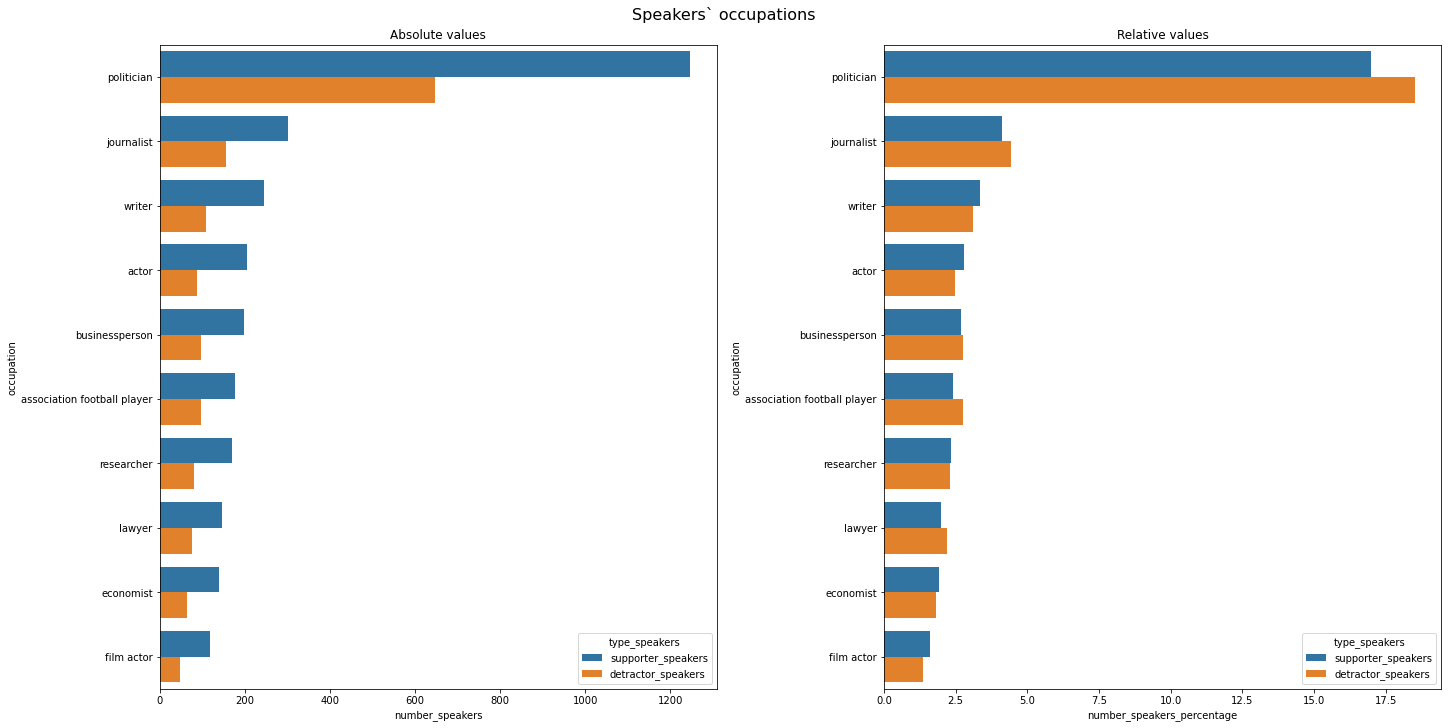

In [63]:
# Plot the results of the speaker's occupation analysis
# Left plot: speaker's occupations absolute values
# Right plot: speaker's occupations relative values
fig, axs = plt.subplots(1, 2,figsize=(20,10), constrained_layout=True)
fig.suptitle('Speakers` occupations', fontsize=16)
sns.barplot(data = df_occupations_long, x = 'number_speakers', y = 'occupation', hue = 'type_speakers', ax = axs[0])
axs[0].set_title('Absolute values')
sns.barplot(data = df_occupations_percentage_long, x = 'number_speakers_percentage', y = 'occupation', hue = 'type_speakers', ax = axs[1])
axs[1].set_title('Relative values')

---
In the same way, as in the analysis of speakers' nationalities, the total number of supporter and detractor speakers is not equal, so it is better to compare relative values regarding the total speakers of each group. Analyzing the relative values, we can conclude that:
- Most of the speaker's occupations has almost the same percentage of supporter and detractor speakers
- Politicians, writers, businesspersons, or television presenters are speaker's occupations with a higher percentage of supporter speakers
- On the other hand, journalists, lawyers, or entrepreneurs have a higher percentage of detractor speakers

---

#### Q4: How did the opinion towards Brexit change during the 6 year span? Did the arguments of each group also change?

In previous sections, we discussed the overall picture of Brexit debate: what percentage of speakers supported or opposed Brexit, what were their arguments and what were their demographics. However, this is just an overall picture, compressing six years of discussions and arguments into a single graph. But with media cycles, emerging topics and constantly changing dynamics of a campaign (or later, negotiations and campaigns), it may be interesting to use previously stated questions and analyse them closer and how they may have changed over a span of time, with three periods considered together.

##### Technical note: graphs to be used

We will track answers to questions Q1-Q3 on a week-by-week basis. The goal of these graphs is to enable us to note 'hot topics' that can arise during a week and notice whether they 'stick'. This also can help us note shifts in opinion across our quotes.

##### Before the referendum

It took some time before the official campaign began, on February 20, 2016 ([source](https://www.bbc.com/news/uk-politics-35621079)), but this doesn't mean that discussions around the topic of United Kingdom did not arise to this date. As mentioned above, a referendum vote between a newly-negotiated agreement with the EU and leaving the Union has been promised in Conservative manifesto for 2015 election, so it may be interesting to look at how arguments and demographics have changed between the start of 2015 and referendum campaign start.

##### The campaign

As campaign progressed, from February to June, we may see more organised messaging from both sides - as every side of the campaign was organised under two umbrella organisations, Britain Stronger In Europe and Vote Leave, it means that those who argue for their side can use resources of their umbrella organizations, alongside various party-oriented (like Labour Leave or Conservatives In) or independent organizations (like Leave.EU or Scientists for EU). This is also a time where both sides may want to reach out directly to voters, leading to more activity on both sides.

##### After the Leave vote

With Leave victory, the discussion has shifted from 'if' to 'how'. From discussion around when to trigger article 50 (of Treaty of the European Union, which described an exit procedure from the EU), to the level of integration with the EU post-Brexit, to Northern Ireland issue and how leaving the EU fits with the framework of Good Friday Agreement - we may expect more arguments around minutiae of the Brexit process.

In [64]:
# To do in next milestone

## 3.5. Modeling


In [65]:
# To do in next milestone

## 3.6. Storytelling and communication

In [66]:
# To do in next milestone

---

# 4. Conclusions

In [67]:
# To do in next milestone

### 4.1. Summary of the notebook


In [68]:
# To do in next milestone

### 4.2. Results obtained


In [69]:
# To do in next milestone

### 4.3. Problems encountered

In [70]:
# To do in next milestone

---

# 5. Future lines

In [71]:
# To do in next milestone